In [11]:
# !pip install tensorflow

In [2]:
import tensorflow as tf
import math
pi = tf.constant(math.pi)

##############################################################################

acc = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP+TN,TN+FP+FN+TP)
prec = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP,FP+TP)
rec = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP,FN+TP)
spec = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TN,FP+TN)
f1s = lambda TN,FP,FN,TP: 2.*tf.math.divide_no_nan(prec(TN,FP,FN,TP)*\
                          rec(TN,FP,FN,TP),prec(TN,FP,FN,TP)+rec(TN,FP,FN,TP))
tss = lambda TN,FP,FN,TP: rec(TN,FP,FN,TP)+spec(TN,FP,FN,TP)-1.
csi = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP,FN+FP+TP)
hss1 = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP-FP,FN+TP)
hss2 = lambda TN,FP,FN,TP: tf.math.divide_no_nan(2.*((TP*TN)-(FP*FN)),((TP+FN)\
                            *(FN+TN))+((TP+FP)*(TN+FP)))
bacc = lambda TN,FP,FN,TP: tf.math.divide_no_nan(rec(TN,FP,FN,TP)+spec(TN,FP,FN,TP),2.0)
    
F_unif = lambda x: x
F_cos = lambda x,mu,delta: tf.where(x<mu-delta,0.,tf.where(x>mu+delta,1.,\
        0.5*(1.+tf.math.divide(x-mu,delta)+1./pi*tf.math.sin(pi*\
         tf.math.divide(x-mu,delta)))))



def SOL(score = 'accuracy', distribution = 'uniform',\
        mu = 0.5, delta = 0.1, mode = 'average'):

    """
    
    Score-Oriented Loss (SOL)

    Compute the expected confusion matrix defined by the following elements
           n
      TP = ∑  y_i * F(p_i)
           n
      TN = ∑  (1 - y_i) * (1 - F(p_i))
          i=1
           n
      FP = ∑  (1 - y_i) * F(p_i)
          i=1
           n
      FN = ∑  y_i * (1 - F(p_i))
          i=1

      where y_i represents the true label, p_i represents the predicted probability given by p_i = sigmoid(x_i) and
      F represents the a priori distribution for the threshold.

      The Score-Oriented loss is defined on the elements of the expected confusion matrix as follows

      loss = - score(TP,TN,FP,FN) + 1,

      where score represents the chosen skill score.

      Example
      if score = 'accuracy'
      then
      loss = - (TP + TN) / (TP + FN + TN + FP) + 1
    
    Authors: Guastavino S. & Marchetti F.

    References: https://arxiv.org/abs/2103.15522

    Usage:
     model.compile(loss=SOL(score = 'accuracy', distribution = 'uniform', mu = 0.5, delta = 0.1, mode = 'average'))

    Parameters
    ----------
    
    score : string, the chosen score used to build the loss. Implemented 
            choices are ['accuracy','precision','recall','specificity',
            'f1_score','tss','csi','hss1','hss2'].
    
    distribution : string, the a priori distribution for the threshold.
                   Implemented choices are ['uniform','cosine'].
             
    mu : scalar in (0,1) or list of scalars in (0,1). If the chosen 
         distribution is 'cosine', mu is the mean of the raised cosine 
         distribution. In the multiclass case, mu can be defined as a list of
         values, one for each one-vs-rest classification, so that
         len(mu) = number of classes. 
         If the the chosen distribution is 'uniform', this parameter is
         ignored.
    
    delta : scalar in (0,1). If the chosen distribution is 'cosine', then
            [mu-delta,mu+delta] is the support of the raised cosine
            distribution. In the multiclass case, delta can be defined as a
            list values, one for each one-vs-rest classification, so that
            len(delta) = number of classes. 
            If the the chosen distribution is 'uniform', this parameter is
            ignored.
    
    mode : string in ['average','weighted']. In the multiclass case, it 
           determines in which way the contributes of the one-vs-rest tasks
           are combined in a unique score. 
           If the problem is not multiclass, this parameter is ignored.
    
    
    """
        
    if score == 'accuracy':
        score = acc
    if score == 'precision':
        score = prec
    if score == 'recall':
        score = rec    
    if score == 'specificity':
        score = spec        
    if score == 'f1_score':
        score = f1s
    if score == 'tss':
        score = tss
    if score == 'csi':
        score = csi
    if score == 'hss1':
        score = hss1        
    if score == 'hss2':
        score = hss2 
    if score == 'bacc':
        score = bacc
        
    if distribution == 'uniform':
        distr = F_unif
        
    if distribution == 'cosine':
        if type(mu) is not list:
            distr = lambda x: F_cos(x,mu,delta)
        else:
            distr = [lambda x: F_cos(x,mu[j],delta[j]) for j in \
                     range(0,len(mu))]
            
    def SOL_(y_true, y_pred):
                
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        if y_pred.shape[1] == 1:   
            
            TN = tf.reduce_sum((1.-y_true)*(1.-distr(y_pred)))
            TP = tf.reduce_sum(y_true*distr(y_pred))
            FP = tf.reduce_sum((1.-y_true)*distr(y_pred))
            FN = tf.reduce_sum(y_true*(1.-distr(y_pred)))
        
            return -score(TN,FP,FN,TP) + 1.
        
        else:
            
            score_arr = []
            num_c0_arr = []
            
            
            for j in range(0,y_pred.shape[1]):
                                 
                y_pred_ = y_pred[:,j]
                y_true_ = y_true[:,j]
                
                if type(mu) is not list:

                    TN = tf.reduce_sum((1.-y_true_)*(1.-distr(y_pred_)))
                    TP = tf.reduce_sum(y_true_*distr(y_pred_))
                    FP = tf.reduce_sum((1.-y_true_)*distr(y_pred_))
                    FN = tf.reduce_sum(y_true_*(1.-distr(y_pred_)))
                
                else:
                
                    TN = tf.reduce_sum((1.-y_true_)*(1.-distr[j](y_pred_)))
                    TP = tf.reduce_sum(y_true_*distr[j](y_pred_))
                    FP = tf.reduce_sum((1.-y_true_)*distr[j](y_pred_))
                    FN = tf.reduce_sum(y_true_*(1.-distr[j](y_pred_)))
                    
                score_arr.append(score(TN,FP,FN,TP))

                if mode == 'weighted':
                    num_c0_arr.append(tf.cast(tf.shape(y_true_)[0],\
                                        tf.float32)-tf.reduce_sum(y_true_))
            
            score_arr = tf.stack(score_arr,axis=0)
            
            if mode == 'weighted':
                num_c0_arr = tf.stack(num_c0_arr,axis=0)
                final_score = tf.math.divide_no_nan(tf.reduce_sum\
                            (score_arr*num_c0_arr),tf.reduce_sum(num_c0_arr))
                
            if mode == 'average':
                final_score = tf.math.reduce_mean(score_arr)
            
            return -final_score + 1.
    
    return SOL_


In [3]:
from sklearn.decomposition import PCA
def pca(df_X, df_y):
    pca = PCA(n_components = 2)
    pca.fit(df_X)
    df_pca = pca.transform(df_X)
    df_pca = pd.DataFrame(df_pca, columns = ['comp. 0', 'comp. 1'])
    df_pca['target'] = df_y
    print('variance ratio:', pca.explained_variance_ratio_, 'sum:', sum(pca.explained_variance_ratio_))
    return df_pca

def concath(df_X, df_y):
    df = pd.concat([df_X, df_y])
    return df

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot as plt
from sklearn import metrics
import tensorflow as tf
import keras
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras import optimizers
import math


################################ MSE ################################
def MSE(y_true, y_pred):
    return tf.reduce_mean(tf.math.square(y_true - y_pred))

################################ BCE ################################
import tensorflow as tf
def BCE(y_true, y_pred):
    return -tf.reduce_mean(y_true*tf.math.log(y_pred)+(1-y_true)*tf.math.log(1-y_pred))

################################ Ours_Accu ################################
def Ours_Accu(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    yl = y_train.shape[0]
    accu = (yl-tf.reduce_sum(y_true)-tf.reduce_sum(y_pred)+2*tf.reduce_sum(y_true*y_pred)) / yl
    return 1-accu

################################ Ours_Fbeta ################################
def Ours_Fbeta(y_true, y_pred):
#     beta = 1 
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    numerator = (1+beta**2)*tf.reduce_sum(y_true*y_pred)
    denominator = (beta**2)*tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1-(numerator/denominator)

################################ Ours_Gmean ################################
def Ours_Gmean(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    syhy = tf.reduce_sum(y_true*y_pred)
    sy = tf.reduce_sum(y_true)
    yl = (y_train.shape[0])
#     gmean = syhy*(yl-tf.reduce_sum(y_pred)-sy+syhy)/(sy*(yl-sy))
    gmean = tf.sqrt(syhy*(yl-tf.reduce_sum(y_pred)-sy+syhy)/(sy*(yl-sy)))
    return 1-gmean

################################ Ours_BAccu ################################
def Ours_BAccu(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    syhy = tf.reduce_sum(y_true*y_pred)
    sy = tf.reduce_sum(y_true)
    yl = y_train.shape[0]
    baccu = (yl*(syhy+sy)-sy*(tf.reduce_sum(y_pred)+sy)) / (2*sy*(yl-sy))
    return 1-baccu

# 1. My own data(2d / 10,000)

In [110]:
from sklearn import datasets
import numpy as np
import pandas as pd
Init_X, Init_y = datasets.make_classification(n_samples=10000, n_classes=2, weights=[0.9, 0.1], class_sep=1.2,
                                    n_features=5, n_informative=3, n_redundant=1, n_clusters_per_class=1, random_state=0)
X = np.array(Init_X)
y = np.array(Init_y)
# # change 0 -> -1
# y = [-1 if x==0 else x for x in y]

df_pca = pca(X, y)
df_pca

variance ratio: [0.42833444 0.25307059] sum: 0.681405030438325


,comp. 0,comp. 1,target
0,1.695416,1.809229,0
1,0.982001,-1.214855,0
2,-0.817025,0.504334,0
3,-0.235227,-0.039080,0
4,-0.534662,-2.206977,0
...,...,...,...
9995,-1.686589,1.869398,1
9996,-0.455202,0.290077,0
9997,-0.970592,-1.940881,0
9998,-2.826011,0.173755,0


In [111]:
df_pca

,comp. 0,comp. 1,target
0,1.695416,1.809229,0
1,0.982001,-1.214855,0
2,-0.817025,0.504334,0
3,-0.235227,-0.039080,0
4,-0.534662,-2.206977,0
...,...,...,...
9995,-1.686589,1.869398,1
9996,-0.455202,0.290077,0
9997,-0.970592,-1.940881,0
9998,-2.826011,0.173755,0


In [112]:
res = pd.DataFrame({'Delta':[0, 0, 0, 0, 0, 0],
                    'BCE':[0, 0, 0, 0, 0, 0],
                    'AccAim':[0, 0, 0, 0, 0, 0],
                    'F1Aim':[0, 0, 0, 0, 0, 0],
                    'F.5Aim':[0, 0, 0, 0, 0, 0],
                    'F2Aim':[0, 0, 0, 0, 0, 0],
                    'GAim':[0, 0, 0, 0, 0, 0],
                    'BAim':[0, 0, 0, 0, 0, 0]}, index = ['Acc','F1','F.5','F2','Gmean','B_Acc'])

In [113]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2)

X = df_pca.iloc[:, :2]
y = df_pca.iloc[:, 2]

In [114]:
L = 73
hidden_node = 2
# momentum=0.9
activation = 'sigmoid'  
kernel_initializer=keras.initializers.he_normal(seed=100)
epochs=100

batch_size:  450
################################################## 1th CV ##################################################


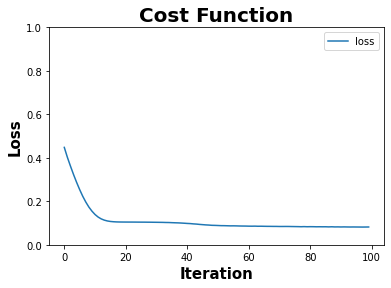

32/32 [==============================] - 0s 537us/step
TN, FP, FN, TP: 876 20 66 38
Accuracy = 0.914
Precesion = 0.6551724137931034
Recall = 0.36538461538461536
F1 = 0.4691358024691358
F0.5 = 0.5654761904761905
F2 = 0.40084388185654
Gmean = 0.5976861289934783
Balanced Accu. = 0.6715315934065934
################################################## 2th CV ##################################################


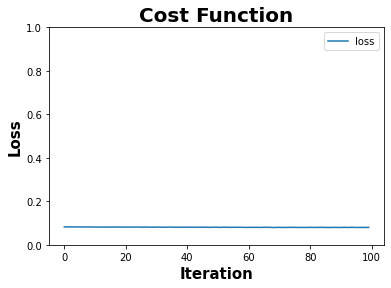

32/32 [==============================] - 0s 507us/step
TN, FP, FN, TP: 877 19 53 51
Accuracy = 0.928
Precesion = 0.7285714285714285
Recall = 0.49038461538461536
F1 = 0.5862068965517241
F0.5 = 0.6640624999999999
F2 = 0.5246913580246914
Gmean = 0.6928100998672161
Balanced Accu. = 0.7345896291208791
################################################## 3th CV ##################################################


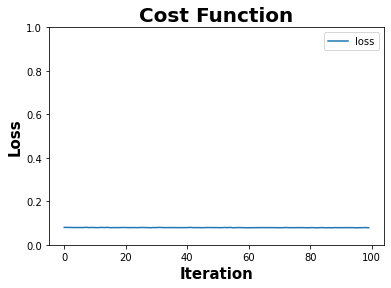

32/32 [==============================] - 0s 498us/step
TN, FP, FN, TP: 878 18 54 50
Accuracy = 0.928
Precesion = 0.7352941176470589
Recall = 0.4807692307692308
F1 = 0.5813953488372093
F0.5 = 0.6648936170212766
F2 = 0.5165289256198347
Gmean = 0.6863752037549654
Balanced Accu. = 0.7303399725274725
################################################## 4th CV ##################################################


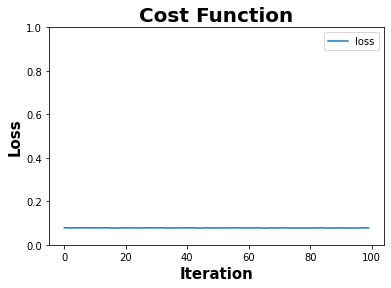

32/32 [==============================] - 0s 508us/step
TN, FP, FN, TP: 872 23 63 42
Accuracy = 0.914
Precesion = 0.6461538461538462
Recall = 0.4
F1 = 0.49411764705882355
F0.5 = 0.5753424657534246
F2 = 0.4329896907216495
Gmean = 0.6242761171076957
Balanced Accu. = 0.6871508379888268
################################################## 5th CV ##################################################


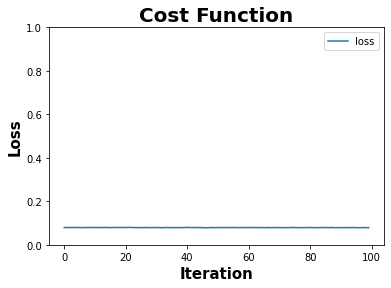

32/32 [==============================] - 0s 498us/step
TN, FP, FN, TP: 883 12 55 50
Accuracy = 0.933
Precesion = 0.8064516129032258
Recall = 0.47619047619047616
F1 = 0.5988023952095808
F0.5 = 0.708215297450425
F2 = 0.5186721991701244
Gmean = 0.6854238100728176
Balanced Accu. = 0.7313913274807129
################################################## 6th CV ##################################################


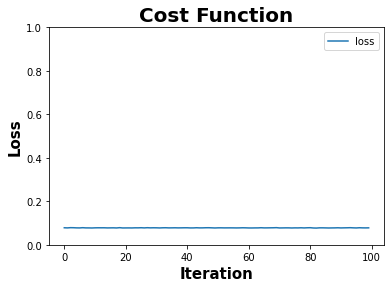

32/32 [==============================] - 0s 528us/step
TN, FP, FN, TP: 872 23 53 52
Accuracy = 0.924
Precesion = 0.6933333333333334
Recall = 0.49523809523809526
F1 = 0.5777777777777777
F0.5 = 0.6419753086419753
F2 = 0.5252525252525253
Gmean = 0.6946303378045455
Balanced Accu. = 0.7347698856078744
################################################## 7th CV ##################################################


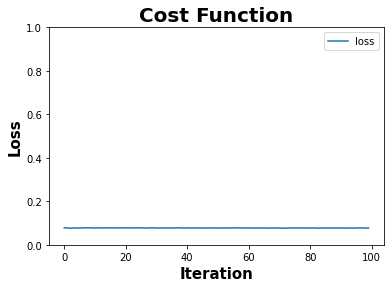

32/32 [==============================] - 0s 517us/step
TN, FP, FN, TP: 871 24 54 51
Accuracy = 0.922
Precesion = 0.68
Recall = 0.4857142857142857
F1 = 0.5666666666666667
F0.5 = 0.6296296296296297
F2 = 0.5151515151515151
Gmean = 0.6875242141857839
Balanced Accu. = 0.7294493216280926
################################################## 8th CV ##################################################


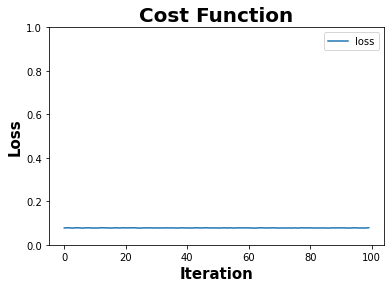

32/32 [==============================] - 0s 501us/step
TN, FP, FN, TP: 869 26 54 51
Accuracy = 0.92
Precesion = 0.6623376623376623
Recall = 0.4857142857142857
F1 = 0.5604395604395604
F0.5 = 0.6174334140435835
F2 = 0.5130784708249496
Gmean = 0.6867344101178448
Balanced Accu. = 0.7283320031923384
################################################## 9th CV ##################################################


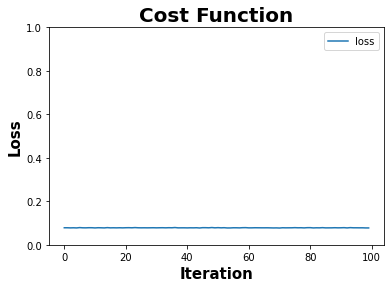

32/32 [==============================] - 0s 514us/step
TN, FP, FN, TP: 874 21 47 58
Accuracy = 0.932
Precesion = 0.7341772151898734
Recall = 0.5523809523809524
F1 = 0.6304347826086957
F0.5 = 0.6888361045130641
F2 = 0.5811623246492985
Gmean = 0.7344522166391791
Balanced Accu. = 0.7644586326150572
################################################## 10th CV ##################################################


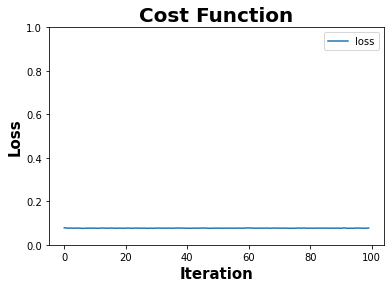

32/32 [==============================] - 0s 489us/step
TN, FP, FN, TP: 872 23 61 44
Accuracy = 0.916
Precesion = 0.6567164179104478
Recall = 0.41904761904761906
F1 = 0.5116279069767442
F0.5 = 0.5898123324396782
F2 = 0.4517453798767967
Gmean = 0.6389669768873354
Balanced Accu. = 0.6966746475126363


In [120]:
acc_acc = []
acc_f1 = []
acc_f5 = []
acc_f2 = []
acc_gmean = []
acc_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  #0.001
print('batch_size: ', batch_size)
learning_rate=0.001

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_pca, df_pca['target']):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'accuracy', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    acc_acc.append((TP+TN)/(TP+TN+FP+FN))
    acc_f1.append(TP / (TP + 0.5*(FP+FN)))
    acc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    acc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    acc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    acc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [121]:
res['AccAim'] = [np.mean(acc_acc), np.mean(acc_f1), np.mean(acc_f5), np.mean(acc_f2), np.mean(acc_gmean), np.mean(acc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.923100,0,0,0,0,0
F1,0,0,0.557660,0,0,0,0,0
F.5,0,0,0.634568,0,0,0,0,0
F2,0,0,0.498012,0,0,0,0,0
Gmean,0,0,0.672888,0,0,0,0,0
B_Acc,0,0,0.720869,0,0,0,0,0


batch_size:  450
################################################## 1th CV ##################################################


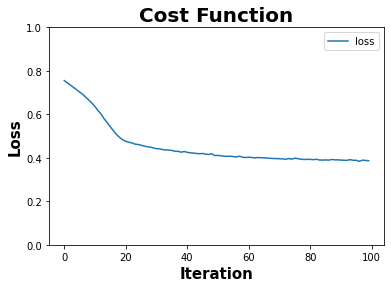

32/32 [==============================] - 0s 515us/step
TN, FP, FN, TP: 827 69 27 77
Accuracy = 0.904
Precesion = 0.5273972602739726
Recall = 0.7403846153846154
F1 = 0.616
F0.5 = 0.559593023255814
F2 = 0.6850533807829181
Gmean = 0.8266609882068204
Balanced Accu. = 0.8316878434065934
################################################## 2th CV ##################################################


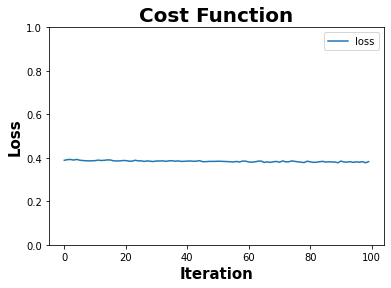

32/32 [==============================] - 0s 525us/step
TN, FP, FN, TP: 832 64 22 82
Accuracy = 0.914
Precesion = 0.5616438356164384
Recall = 0.7884615384615384
F1 = 0.656
F0.5 = 0.5959302325581396
F2 = 0.7295373665480427
Gmean = 0.8556534679079242
Balanced Accu. = 0.8585164835164836
################################################## 3th CV ##################################################


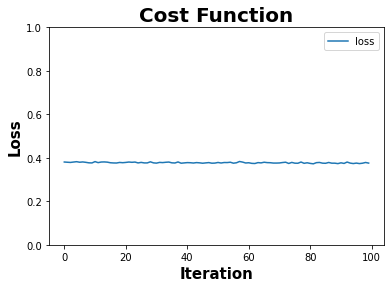

32/32 [==============================] - 0s 529us/step
TN, FP, FN, TP: 846 50 27 77
Accuracy = 0.923
Precesion = 0.6062992125984252
Recall = 0.7403846153846154
F1 = 0.6666666666666666
F0.5 = 0.6290849673202614
F2 = 0.70902394106814
Gmean = 0.8361031692413232
Balanced Accu. = 0.842290521978022
################################################## 4th CV ##################################################


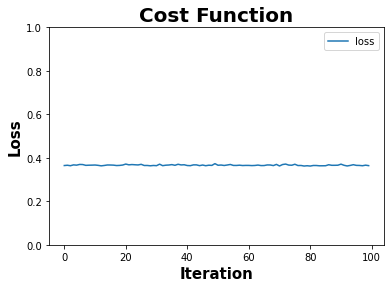

32/32 [==============================] - 0s 545us/step
TN, FP, FN, TP: 840 55 46 59
Accuracy = 0.899
Precesion = 0.5175438596491229
Recall = 0.5619047619047619
F1 = 0.5388127853881278
F0.5 = 0.5258467023172906
F2 = 0.5524344569288389
Gmean = 0.726205412866069
Balanced Accu. = 0.7502261239691408
################################################## 5th CV ##################################################


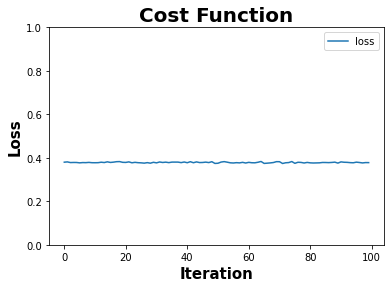

32/32 [==============================] - 0s 540us/step
TN, FP, FN, TP: 857 38 27 78
Accuracy = 0.935
Precesion = 0.6724137931034483
Recall = 0.7428571428571429
F1 = 0.7058823529411765
F0.5 = 0.6854130052724077
F2 = 0.7276119402985075
Gmean = 0.8433960158697669
Balanced Accu. = 0.8501995211492419
################################################## 6th CV ##################################################


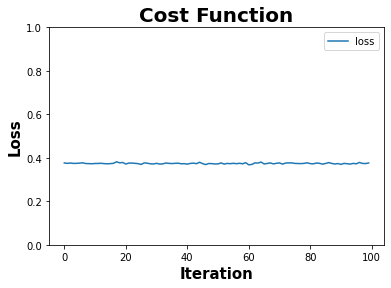

32/32 [==============================] - 0s 521us/step
TN, FP, FN, TP: 839 56 23 82
Accuracy = 0.921
Precesion = 0.5942028985507246
Recall = 0.780952380952381
F1 = 0.6748971193415638
F0.5 = 0.624048706240487
F2 = 0.7347670250896057
Gmean = 0.855621599401315
Balanced Accu. = 0.8591912742750731
################################################## 7th CV ##################################################


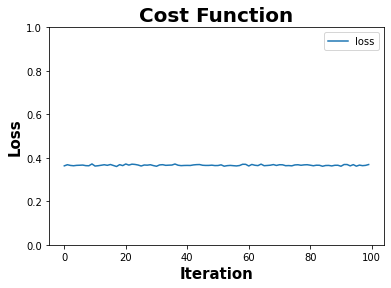

32/32 [==============================] - 0s 583us/step
TN, FP, FN, TP: 847 48 37 68
Accuracy = 0.915
Precesion = 0.5862068965517241
Recall = 0.6476190476190476
F1 = 0.6153846153846154
F0.5 = 0.5975395430579964
F2 = 0.6343283582089553
Gmean = 0.7828706189141547
Balanced Accu. = 0.7969938813514232
################################################## 8th CV ##################################################


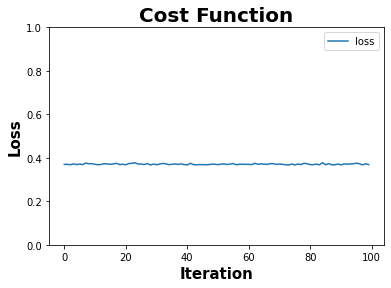

32/32 [==============================] - 0s 559us/step
TN, FP, FN, TP: 839 56 29 76
Accuracy = 0.915
Precesion = 0.5757575757575758
Recall = 0.7238095238095238
F1 = 0.6413502109704642
F0.5 = 0.6003159557661927
F2 = 0.6884057971014492
Gmean = 0.823723790608005
Balanced Accu. = 0.8306198457036446
################################################## 9th CV ##################################################


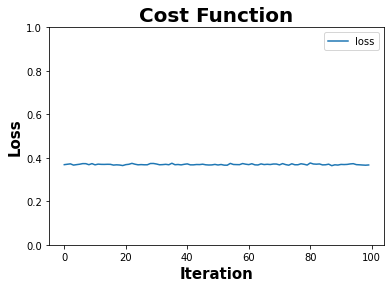

32/32 [==============================] - 0s 549us/step
TN, FP, FN, TP: 836 59 28 77
Accuracy = 0.913
Precesion = 0.5661764705882353
Recall = 0.7333333333333333
F1 = 0.6390041493775933
F0.5 = 0.5932203389830508
F2 = 0.6924460431654677
Gmean = 0.8276416428702916
Balanced Accu. = 0.833705772811918
################################################## 10th CV ##################################################


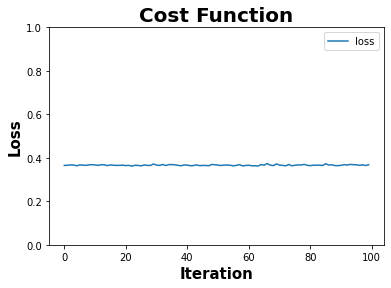

32/32 [==============================] - 0s 543us/step
TN, FP, FN, TP: 834 61 32 73
Accuracy = 0.907
Precesion = 0.5447761194029851
Recall = 0.6952380952380952
F1 = 0.6108786610878661
F0.5 = 0.5694227769110763
F2 = 0.6588447653429602
Gmean = 0.8048932553041788
Balanced Accu. = 0.8135408353285448


In [122]:
f1_acc = []
f1_f1 = []
f1_f5 = []
f1_f2 = []
f1_gmean = []
f1_bacc = []
n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05) 
print('batch_size: ', batch_size)
learning_rate=0.001

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_pca, df_pca['target']):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'f1_score', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    f1_acc.append((TP+TN)/(TP+TN+FP+FN))
    f1_f1.append(TP / (TP + 0.5*(FP+FN)))
    f1_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    f1_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    f1_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    f1_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [123]:
res['F1Aim'] = [np.mean(f1_acc), np.mean(f1_f1), np.mean(f1_f5), np.mean(f1_f2), np.mean(f1_gmean), np.mean(f1_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.923100,0.914600,0,0,0,0
F1,0,0,0.557660,0.636488,0,0,0,0
F.5,0,0,0.634568,0.598042,0,0,0,0
F2,0,0,0.498012,0.681245,0,0,0,0
Gmean,0,0,0.672888,0.818277,0,0,0,0
B_Acc,0,0,0.720869,0.826697,0,0,0,0


batch_size:  4500
################################################## 1th CV ##################################################


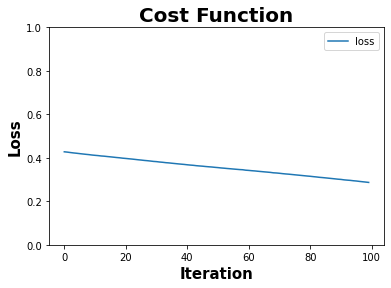

32/32 [==============================] - 0s 512us/step
TN, FP, FN, TP: 571 325 24 80
Accuracy = 0.651
Precesion = 0.19753086419753085
Recall = 0.7692307692307693
F1 = 0.3143418467583497
F0.5 = 0.23201856148491878
F2 = 0.48721071863581
Gmean = 0.7001520635461358
Balanced Accu. = 0.7032537774725275
################################################## 2th CV ##################################################


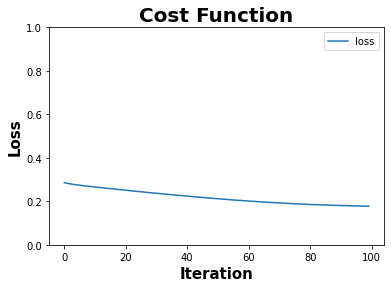

32/32 [==============================] - 0s 506us/step
TN, FP, FN, TP: 726 170 6 98
Accuracy = 0.824
Precesion = 0.3656716417910448
Recall = 0.9423076923076923
F1 = 0.5268817204301075
F0.5 = 0.4166666666666667
F2 = 0.7163742690058479
Gmean = 0.8737972502905835
Balanced Accu. = 0.8762877747252746
################################################## 3th CV ##################################################


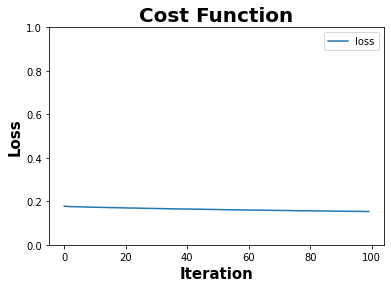

32/32 [==============================] - 0s 546us/step
TN, FP, FN, TP: 746 150 7 97
Accuracy = 0.843
Precesion = 0.39271255060728744
Recall = 0.9326923076923077
F1 = 0.5527065527065527
F0.5 = 0.4441391941391941
F2 = 0.7315233785822022
Gmean = 0.8812205298634089
Balanced Accu. = 0.8826407967032968
################################################## 4th CV ##################################################


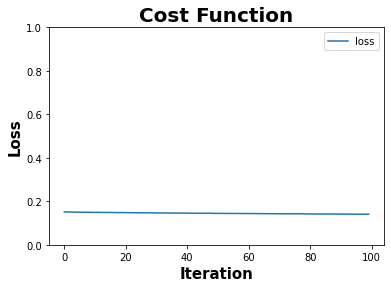

32/32 [==============================] - 0s 514us/step
TN, FP, FN, TP: 747 148 7 98
Accuracy = 0.845
Precesion = 0.3983739837398374
Recall = 0.9333333333333333
F1 = 0.5584045584045584
F0.5 = 0.44995408631772266
F2 = 0.7357357357357358
Gmean = 0.8826066017245855
Balanced Accu. = 0.8839851024208566
################################################## 5th CV ##################################################


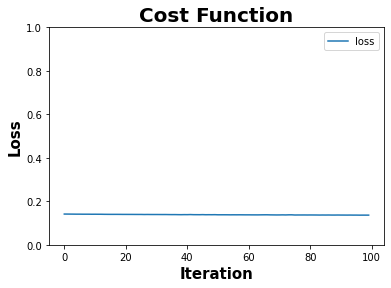

32/32 [==============================] - 0s 554us/step
TN, FP, FN, TP: 751 144 8 97
Accuracy = 0.848
Precesion = 0.4024896265560166
Recall = 0.9238095238095239
F1 = 0.5606936416184971
F0.5 = 0.45369504209541633
F2 = 0.7337367624810893
Gmean = 0.8804398040015785
Balanced Accu. = 0.8814578345304602
################################################## 6th CV ##################################################


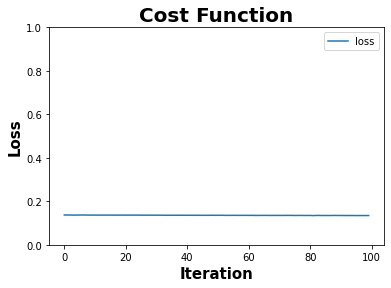

32/32 [==============================] - 0s 538us/step
TN, FP, FN, TP: 747 148 7 98
Accuracy = 0.845
Precesion = 0.3983739837398374
Recall = 0.9333333333333333
F1 = 0.5584045584045584
F0.5 = 0.44995408631772266
F2 = 0.7357357357357358
Gmean = 0.8826066017245855
Balanced Accu. = 0.8839851024208566
################################################## 7th CV ##################################################


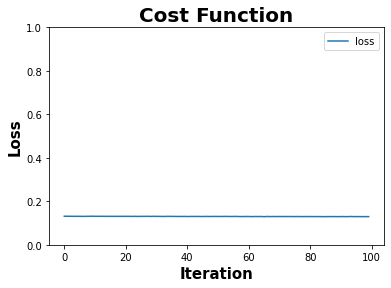

32/32 [==============================] - 0s 510us/step
TN, FP, FN, TP: 759 136 12 93
Accuracy = 0.852
Precesion = 0.40611353711790393
Recall = 0.8857142857142857
F1 = 0.5568862275449101
F0.5 = 0.45543584720861896
F2 = 0.7164869029275809
Gmean = 0.8666748521110578
Balanced Accu. = 0.866879489225858
################################################## 8th CV ##################################################


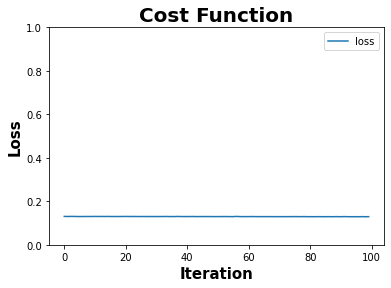

32/32 [==============================] - 0s 512us/step
TN, FP, FN, TP: 757 138 12 93
Accuracy = 0.85
Precesion = 0.4025974025974026
Recall = 0.8857142857142857
F1 = 0.5535714285714286
F0.5 = 0.4518950437317784
F2 = 0.7142857142857143
Gmean = 0.8655322348019426
Balanced Accu. = 0.8657621707901038
################################################## 9th CV ##################################################


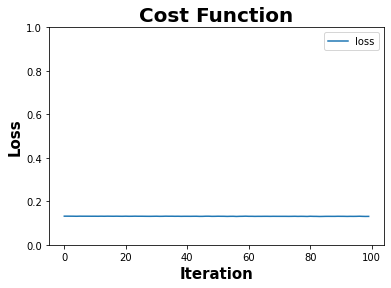

32/32 [==============================] - 0s 535us/step
TN, FP, FN, TP: 769 126 9 96
Accuracy = 0.865
Precesion = 0.43243243243243246
Recall = 0.9142857142857143
F1 = 0.5871559633027523
F0.5 = 0.4833836858006042
F2 = 0.7476635514018691
Gmean = 0.8863242242468788
Balanced Accu. = 0.8867517956903432
################################################## 10th CV ##################################################


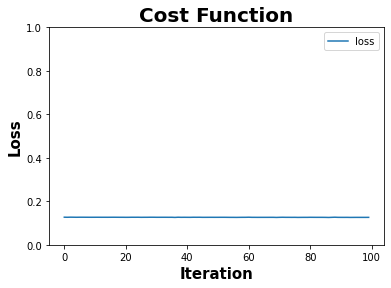

32/32 [==============================] - 0s 533us/step
TN, FP, FN, TP: 760 135 16 89
Accuracy = 0.849
Precesion = 0.39732142857142855
Recall = 0.8476190476190476
F1 = 0.541033434650456
F0.5 = 0.4445554445554446
F2 = 0.6909937888198757
Gmean = 0.8483901786235444
Balanced Accu. = 0.848390529396116


In [125]:
bacc_acc = []
bacc_f1 = []
bacc_f5 = []
bacc_f2 = []
bacc_gmean = []
bacc_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.5) 
print('batch_size: ', batch_size)
learning_rate=0.02

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_pca, df_pca['target']):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'bacc', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    bacc_acc.append((TP+TN)/(TP+TN+FP+FN))
    bacc_f1.append(TP / (TP + 0.5*(FP+FN)))
    bacc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    bacc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    bacc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    bacc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [126]:
res['BAim'] = [np.mean(bacc_acc), np.mean(bacc_f1), np.mean(bacc_f5), np.mean(bacc_f2), np.mean(bacc_gmean), np.mean(bacc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.923100,0.914600,0,0,0,0.827200
F1,0,0,0.557660,0.636488,0,0,0,0.531008
F.5,0,0,0.634568,0.598042,0,0,0,0.428170
F2,0,0,0.498012,0.681245,0,0,0,0.700975
Gmean,0,0,0.672888,0.818277,0,0,0,0.856774
B_Acc,0,0,0.720869,0.826697,0,0,0,0.857939


# 2. Creditcard Fraud Detection 2023(29d / 298531)

In [154]:
# class '0' = normal, class '1' = anomaly
card_df = pd.read_csv('creditcard_2023.csv')
card_df.shape

(568630, 31)

In [155]:
# 결측치 확인
card_df.isnull().sum()

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [156]:
card_df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [157]:
card_df.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630.000000,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,284314.500000,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,...,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,12041.957635,0.5
std,164149.486122,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,0.000000,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,...,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,142157.250000,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,...,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,284314.500000,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,...,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,426471.750000,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,...,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000,1.0
max,568629.000000,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,...,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000,1.0


In [158]:
# Amount values largely varies.

# # Normalization
# card_df.iloc[:,:-1] = (card_df.iloc[:,:-1] - card_df.iloc[:,:-1].min())/(card_df.iloc[:,:-1].max() - card_df.iloc[:,:-1].min())

# Standardization
card_df.iloc[:,:-1] = (card_df.iloc[:,:-1] - card_df.iloc[:,:-1].mean())/card_df.iloc[:,:-1].std()

card_df

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.732046,-0.260648,-0.469648,2.496264,-0.083724,0.129681,0.732898,0.519013,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0.858446,0
1,-1.732040,0.985099,-0.356045,0.558056,-0.429654,0.277140,0.428604,0.406466,-0.133118,0.347452,...,-0.194936,-0.605760,0.079469,-0.577394,0.190090,0.296502,-0.248052,-0.064512,-0.796369,0
2,-1.732034,-0.260271,-0.949384,1.728536,-0.457986,0.074062,1.419480,0.743510,-0.095576,-0.261296,...,-0.005020,0.702906,0.945045,-1.154665,-0.605563,-0.312894,-0.300258,-0.244718,-1.377010,0
3,-1.732028,-0.152152,-0.508958,1.746839,-1.090177,0.249486,1.143311,0.518268,-0.065130,-0.205697,...,-0.146927,-0.038212,-0.214048,-1.893129,1.003962,-0.515950,-0.165316,0.048424,-0.962118,0
4,-1.732022,-0.206819,-0.165280,1.527051,-0.448292,0.106125,0.530548,0.658849,-0.212660,1.049920,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071125,0.023712,0.419117,0.323284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,1.732022,-0.833437,0.061886,-0.899793,0.904226,-1.002400,0.481453,-0.370393,0.189693,-0.938152,...,0.167503,0.419731,1.288248,-0.900860,0.560661,-0.006018,3.308965,0.081564,-1.105230,1
568626,1.732028,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483893,...,0.031874,0.388161,-0.154257,-0.846451,-0.153443,1.961396,-1.528640,1.704305,-1.067766,1
568627,1.732034,-0.311997,-0.004095,0.137525,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,...,0.140787,0.536522,-0.211100,-0.448908,0.540073,-0.755835,-0.487539,-0.268741,1.666400,1
568628,1.732040,0.636870,-0.516969,-0.300888,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893526,...,-0.060380,-0.195609,-0.175487,-0.554643,-0.099669,-1.434930,-0.159269,-0.076251,-0.271853,1


In [159]:
card_df['Class'].value_counts()

0    284315
1    284315
Name: Class, dtype: int64

In [160]:
# Data is too balanced!!! We intentionally make it imbalanced.
df_0 = card_df[card_df['Class']==0]
df_1 = card_df[card_df['Class']==1]
print(len(df_0), len(df_1))

284315 284315


In [161]:
N = round(len(df_0)*0.05)
df_1_samp = df_1.sample(n=N, random_state = 100)
df_1_samp

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
506274,1.352179,-0.006870,-0.167584,-0.426402,0.286979,3.061201,-1.574602,0.044742,-0.428210,0.154000,...,-0.386374,-0.470302,-1.743519,-1.185101,-1.558751,-1.397993,-0.012629,0.450646,1.114237,1
387527,0.628771,-1.505330,0.343708,-1.307073,1.727683,-0.524436,-2.021618,-2.304781,-0.078004,-1.148383,...,-0.427704,-1.212065,-12.554995,0.951595,-5.763942,0.191730,3.949965,-1.475321,-0.071128,1
365951,0.497330,-0.503065,0.153162,-0.422713,-0.354370,-0.419048,-0.107715,0.314880,-0.203583,0.279555,...,0.037084,-0.209385,0.549983,0.396777,-1.430279,-2.486924,-0.617871,0.560011,-1.321357,1
525848,1.471424,-1.021538,-1.187974,-0.746483,-0.029644,0.009252,-0.507414,0.471536,-0.015704,-0.207999,...,0.018479,0.766577,0.123668,0.268437,0.800809,0.413684,-0.034178,-0.097596,1.445303,1
481288,1.199964,-0.509792,0.194382,-0.386280,-0.611187,0.135320,0.440036,-0.240672,-0.615084,0.251804,...,-0.095779,0.402399,-0.251087,-0.566821,0.409498,-1.473372,-0.251349,-0.044765,-0.010947,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491209,1.260403,-1.088031,0.682312,-0.917454,0.643955,-0.652642,-0.555339,-0.667876,0.288458,-0.764149,...,0.528281,0.386071,0.095967,1.123651,-0.015030,0.636864,-1.803348,1.164825,-0.080206,1
372018,0.534290,-2.281503,2.701140,-2.214454,1.222394,-2.728423,-2.561828,-2.136703,4.308934,-1.151728,...,0.558177,-1.432524,-0.994643,0.310707,2.660860,-0.516013,1.909650,0.968061,0.731649,1
343903,0.363014,-0.267325,0.352643,-0.836113,0.475835,-0.673489,-0.723249,-0.492036,0.200382,-0.714633,...,0.283521,0.720715,0.230679,0.010768,-0.039101,1.150750,0.024092,-0.461128,0.646750,1
452083,1.022047,-2.174120,2.531664,-2.126482,1.202406,-2.566989,-2.477827,-2.045211,3.892891,-1.178189,...,0.554093,-1.297113,-0.862695,0.284146,2.371527,-0.520116,2.028946,1.024555,0.740116,1


In [162]:
df_card = concath(df_0, df_1_samp)
df_card

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.732046,-0.260648,-0.469648,2.496264,-0.083724,0.129681,0.732898,0.519013,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0.858446,0
1,-1.732040,0.985099,-0.356045,0.558056,-0.429654,0.277140,0.428604,0.406466,-0.133118,0.347452,...,-0.194936,-0.605760,0.079469,-0.577394,0.190090,0.296502,-0.248052,-0.064512,-0.796369,0
2,-1.732034,-0.260271,-0.949384,1.728536,-0.457986,0.074062,1.419480,0.743510,-0.095576,-0.261296,...,-0.005020,0.702906,0.945045,-1.154665,-0.605563,-0.312894,-0.300258,-0.244718,-1.377010,0
3,-1.732028,-0.152152,-0.508958,1.746839,-1.090177,0.249486,1.143311,0.518268,-0.065130,-0.205697,...,-0.146927,-0.038212,-0.214048,-1.893129,1.003962,-0.515950,-0.165316,0.048424,-0.962118,0
4,-1.732022,-0.206819,-0.165280,1.527051,-0.448292,0.106125,0.530548,0.658849,-0.212660,1.049920,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071125,0.023712,0.419117,0.323284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491209,1.260403,-1.088031,0.682312,-0.917454,0.643955,-0.652642,-0.555339,-0.667876,0.288458,-0.764149,...,0.528281,0.386071,0.095967,1.123651,-0.015030,0.636864,-1.803348,1.164825,-0.080206,1
372018,0.534290,-2.281503,2.701140,-2.214454,1.222394,-2.728423,-2.561828,-2.136703,4.308934,-1.151728,...,0.558177,-1.432524,-0.994643,0.310707,2.660860,-0.516013,1.909650,0.968061,0.731649,1
343903,0.363014,-0.267325,0.352643,-0.836113,0.475835,-0.673489,-0.723249,-0.492036,0.200382,-0.714633,...,0.283521,0.720715,0.230679,0.010768,-0.039101,1.150750,0.024092,-0.461128,0.646750,1
452083,1.022047,-2.174120,2.531664,-2.126482,1.202406,-2.566989,-2.477827,-2.045211,3.892891,-1.178189,...,0.554093,-1.297113,-0.862695,0.284146,2.371527,-0.520116,2.028946,1.024555,0.740116,1


In [163]:
df_card.columns

Index(['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [164]:
df_card = df_card.drop('id', axis=1)
df_card

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.260648,-0.469648,2.496264,-0.083724,0.129681,0.732898,0.519013,-0.130006,0.727159,0.637734,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0.858446,0
1,0.985099,-0.356045,0.558056,-0.429654,0.277140,0.428604,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605760,0.079469,-0.577394,0.190090,0.296502,-0.248052,-0.064512,-0.796369,0
2,-0.260271,-0.949384,1.728536,-0.457986,0.074062,1.419480,0.743510,-0.095576,-0.261296,0.690707,...,-0.005020,0.702906,0.945045,-1.154665,-0.605563,-0.312894,-0.300258,-0.244718,-1.377010,0
3,-0.152152,-0.508958,1.746839,-1.090177,0.249486,1.143311,0.518268,-0.065130,-0.205697,0.575230,...,-0.146927,-0.038212,-0.214048,-1.893129,1.003962,-0.515950,-0.165316,0.048424,-0.962118,0
4,-0.206819,-0.165280,1.527051,-0.448292,0.106125,0.530548,0.658849,-0.212660,1.049920,0.968045,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071125,0.023712,0.419117,0.323284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491209,-1.088031,0.682312,-0.917454,0.643955,-0.652642,-0.555339,-0.667876,0.288458,-0.764149,-0.665831,...,0.528281,0.386071,0.095967,1.123651,-0.015030,0.636864,-1.803348,1.164825,-0.080206,1
372018,-2.281503,2.701140,-2.214454,1.222394,-2.728423,-2.561828,-2.136703,4.308934,-1.151728,-1.283930,...,0.558177,-1.432524,-0.994643,0.310707,2.660860,-0.516013,1.909650,0.968061,0.731649,1
343903,-0.267325,0.352643,-0.836113,0.475835,-0.673489,-0.723249,-0.492036,0.200382,-0.714633,-0.660779,...,0.283521,0.720715,0.230679,0.010768,-0.039101,1.150750,0.024092,-0.461128,0.646750,1
452083,-2.174120,2.531664,-2.126482,1.202406,-2.566989,-2.477827,-2.045211,3.892891,-1.178189,-1.315622,...,0.554093,-1.297113,-0.862695,0.284146,2.371527,-0.520116,2.028946,1.024555,0.740116,1


In [165]:
res = pd.DataFrame({'Delta':[0, 0, 0, 0, 0, 0],
                    'BCE':[0, 0, 0, 0, 0, 0],
                    'AccAim':[0, 0, 0, 0, 0, 0],
                    'F1Aim':[0, 0, 0, 0, 0, 0],
                    'F.5Aim':[0, 0, 0, 0, 0, 0],
                    'F2Aim':[0, 0, 0, 0, 0, 0],
                    'GAim':[0, 0, 0, 0, 0, 0],
                    'BAim':[0, 0, 0, 0, 0, 0]}, index = ['Acc','F1','F.5','F2','Gmean','B_Acc'])

In [166]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2)

X = df_card.iloc[:, :-1]
y = df_card.iloc[:, -1]

In [167]:
L = 73
hidden_node = 2
# momentum=0.9
activation = 'sigmoid'  
kernel_initializer=keras.initializers.he_normal(seed=100)
epochs=100

batch_size:  13433
################################################## 1th CV ##################################################


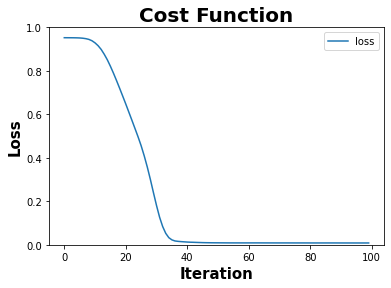

933/933 [==============================] - 1s 473us/step
TN, FP, FN, TP: 28429 3 238 1184
Accuracy = 0.9919273799155892
Precesion = 0.9974726200505476
Recall = 0.8326300984528833
F1 = 0.9076274434649291
F0.5 = 0.9594813614262561
F2 = 0.8610909090909091
Gmean = 0.9124375285797224
Balanced Accu. = 0.9162622917700545
################################################## 2th CV ##################################################


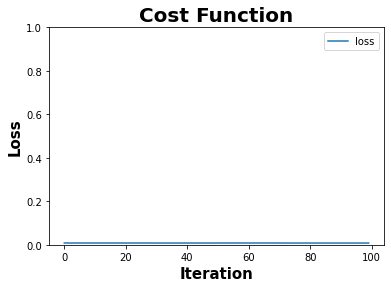

933/933 [==============================] - 0s 454us/step
TN, FP, FN, TP: 28424 8 229 1192
Accuracy = 0.9920610993869963
Precesion = 0.9933333333333333
Recall = 0.8388458831808585
F1 = 0.9095764975200306
F0.5 = 0.9580453303327439
F2 = 0.8657757117954678
Gmean = 0.9157564384232698
Balanced Accu. = 0.9192822550400634
################################################## 3th CV ##################################################


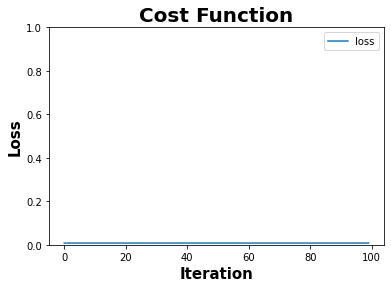

933/933 [==============================] - 0s 443us/step
TN, FP, FN, TP: 28422 10 232 1189
Accuracy = 0.9918936120322915
Precesion = 0.9916597164303587
Recall = 0.8367346938775511
F1 = 0.9076335877862596
F0.5 = 0.9562489946919736
F2 = 0.8637222141508064
Gmean = 0.9145711566539908
Balanced Accu. = 0.9181914887508182
################################################## 4th CV ##################################################


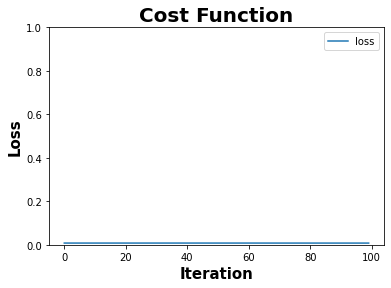

933/933 [==============================] - 0s 449us/step
TN, FP, FN, TP: 28425 7 238 1183
Accuracy = 0.9917931196194687
Precesion = 0.9941176470588236
Recall = 0.8325123152709359
F1 = 0.9061662198391421
F0.5 = 0.9569648924122311
F2 = 0.8604887983706719
Gmean = 0.9123088016241179
Balanced Accu. = 0.9161330569038979
################################################## 5th CV ##################################################


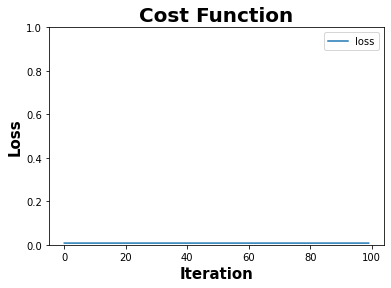

933/933 [==============================] - 0s 449us/step
TN, FP, FN, TP: 28423 9 242 1179
Accuracy = 0.991592134793823
Precesion = 0.9924242424242424
Recall = 0.8296973961998593
F1 = 0.9037945573016481
F0.5 = 0.9549651709055563
F2 = 0.8578288707799767
Gmean = 0.910733089249914
Balanced Accu. = 0.9146904257307682
################################################## 6th CV ##################################################


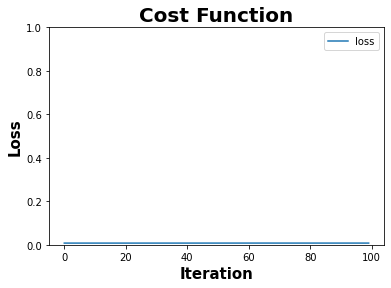

933/933 [==============================] - 0s 443us/step
TN, FP, FN, TP: 28417 14 228 1194
Accuracy = 0.9918936120322915
Precesion = 0.9884105960264901
Recall = 0.8396624472573839
F1 = 0.9079847908745247
F0.5 = 0.9545890629996803
F2 = 0.8657192575406032
Gmean = 0.9161053326277294
Balanced Accu. = 0.9195850135059387
################################################## 7th CV ##################################################


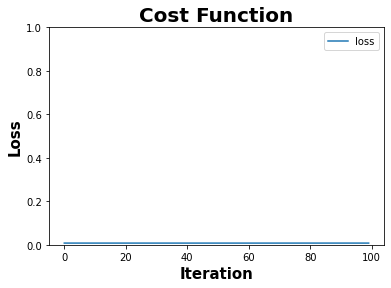

933/933 [==============================] - 0s 443us/step
TN, FP, FN, TP: 28423 8 223 1199
Accuracy = 0.992262084212642
Precesion = 0.9933719966859983
Recall = 0.8431786216596343
F1 = 0.9121338912133892
F0.5 = 0.9592
F2 = 0.8694706308919506
Gmean = 0.9181183831792612
Balanced Accu. = 0.9214486193311009
################################################## 8th CV ##################################################


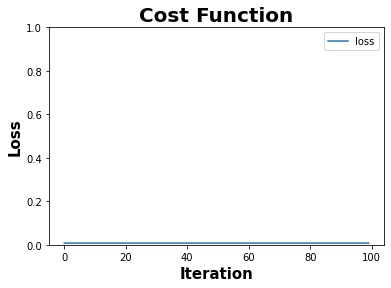

933/933 [==============================] - 0s 443us/step
TN, FP, FN, TP: 28418 13 213 1209
Accuracy = 0.9924295715673467
Precesion = 0.9893617021276596
Recall = 0.8502109704641351
F1 = 0.9145234493192134
F0.5 = 0.9580031695721077
F2 = 0.8748191027496383
Gmean = 0.9218580225464448
Balanced Accu. = 0.9248768615466537
################################################## 9th CV ##################################################


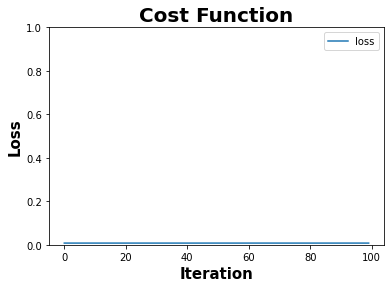

933/933 [==============================] - 0s 446us/step
TN, FP, FN, TP: 28427 4 211 1211
Accuracy = 0.9927980437476971
Precesion = 0.9967078189300411
Recall = 0.8516174402250352
F1 = 0.9184679560106181
F0.5 = 0.963865011142948
F2 = 0.8771548602057078
Gmean = 0.9227662894205862
Balanced Accu. = 0.9257383743631595
################################################## 10th CV ##################################################


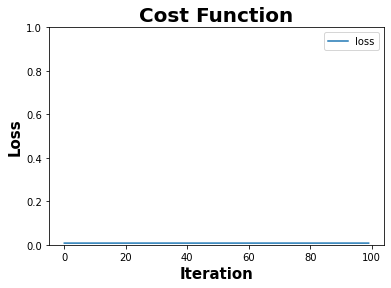

933/933 [==============================] - 0s 436us/step
TN, FP, FN, TP: 28425 6 224 1198
Accuracy = 0.9922955816835829
Precesion = 0.9950166112956811
Recall = 0.8424753867791842
F1 = 0.9124143183549124
F0.5 = 0.9602436678422572
F2 = 0.8691236215902495
Gmean = 0.9177677228427615
Balanced Accu. = 0.921132174765555


In [171]:
acc_acc = []
acc_f1 = []
acc_f5 = []
acc_f2 = []
acc_gmean = []
acc_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  
print('batch_size: ', batch_size)
learning_rate=0.005

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_card, df_card.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'accuracy', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    acc_acc.append((TP+TN)/(TP+TN+FP+FN))
    acc_f1.append(TP / (TP + 0.5*(FP+FN)))
    acc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    acc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    acc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    acc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [172]:
res['AccAim'] = [np.mean(acc_acc), np.mean(acc_f1), np.mean(acc_f5), np.mean(acc_f2), np.mean(acc_gmean), np.mean(acc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.992095,0,0,0,0,0
F1,0,0,0.910032,0,0,0,0,0
F.5,0,0,0.958161,0,0,0,0,0
F2,0,0,0.866519,0,0,0,0,0
Gmean,0,0,0.916242,0,0,0,0,0
B_Acc,0,0,0.919734,0,0,0,0,0


batch_size:  13433
################################################## 1th CV ##################################################


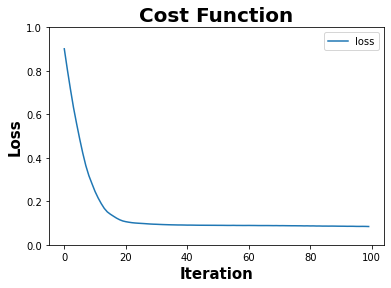

933/933 [==============================] - 0s 444us/step
TN, FP, FN, TP: 28424 8 190 1232
Accuracy = 0.993367722918202
Precesion = 0.9935483870967742
Recall = 0.8663853727144867
F1 = 0.9256198347107438
F0.5 = 0.9652146662488248
F2 = 0.8891454965357968
Gmean = 0.9306672848960242
Balanced Accu. = 0.9330519998068776
################################################## 2th CV ##################################################


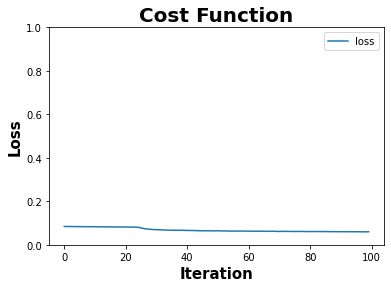

933/933 [==============================] - 0s 453us/step
TN, FP, FN, TP: 28408 24 117 1304
Accuracy = 0.9952768565973269
Precesion = 0.9819277108433735
Recall = 0.9176636171710063
F1 = 0.9487086213168425
F0.5 = 0.9683647705331946
F2 = 0.9298345693097548
Gmean = 0.9575432103037598
Balanced Accu. = 0.9584097489344058
################################################## 3th CV ##################################################


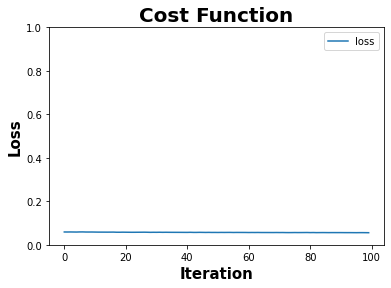

933/933 [==============================] - 0s 430us/step
TN, FP, FN, TP: 28405 27 126 1295
Accuracy = 0.9948748869460355
Precesion = 0.9795763993948563
Recall = 0.9113300492610837
F1 = 0.9442216551221291
F0.5 = 0.9651214786108213
F2 = 0.9242078218669711
Gmean = 0.954182696900953
Balanced Accu. = 0.9551902075230574
################################################## 4th CV ##################################################


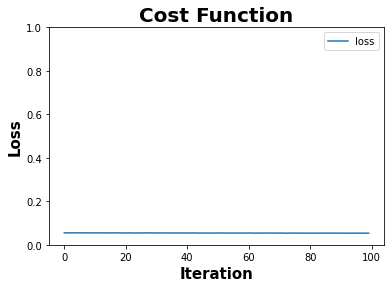

933/933 [==============================] - 0s 440us/step
TN, FP, FN, TP: 28397 35 132 1289
Accuracy = 0.9944059223528624
Precesion = 0.9735649546827795
Recall = 0.9071076706544687
F1 = 0.9391621129326048
F0.5 = 0.9595057317254726
F2 = 0.9196632420091325
Gmean = 0.9518356026519312
Balanced Accu. = 0.952938331669384
################################################## 5th CV ##################################################


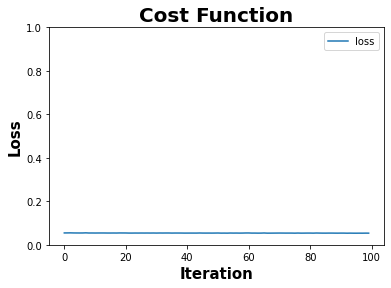

933/933 [==============================] - 0s 434us/step
TN, FP, FN, TP: 28405 27 117 1304
Accuracy = 0.9951763641845041
Precesion = 0.9797145003756574
Recall = 0.9176636171710063
F1 = 0.9476744186046512
F0.5 = 0.9666419570051891
F2 = 0.9294369208838203
Gmean = 0.9574926487458316
Balanced Accu. = 0.9583569914780186
################################################## 6th CV ##################################################


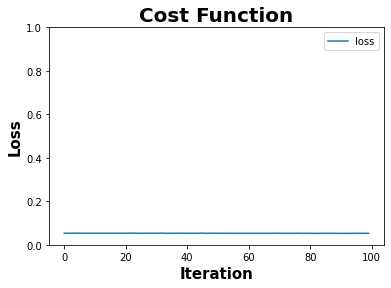

933/933 [==============================] - 0s 441us/step
TN, FP, FN, TP: 28396 35 124 1298
Accuracy = 0.9946739021203899
Precesion = 0.9737434358589647
Recall = 0.9127988748241913
F1 = 0.9422867513611616
F0.5 = 0.9609120521172638
F2 = 0.9243697478991596
Gmean = 0.9548168270454251
Balanced Accu. = 0.9557839121052123
################################################## 7th CV ##################################################


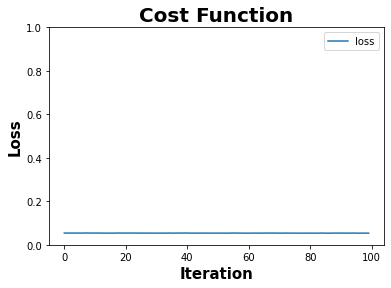

933/933 [==============================] - 0s 454us/step
TN, FP, FN, TP: 28402 29 102 1320
Accuracy = 0.9956118313067364
Precesion = 0.9785025945144552
Recall = 0.9282700421940928
F1 = 0.9527246481414652
F0.5 = 0.9680258140217072
F2 = 0.9378996731561746
Gmean = 0.962976216915082
Balanced Accu. = 0.9636250144142002
################################################## 8th CV ##################################################


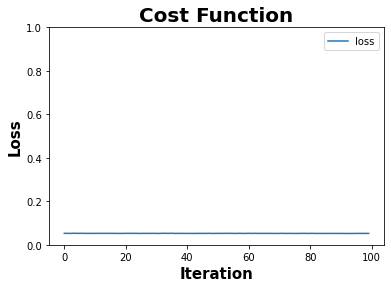

933/933 [==============================] - 0s 458us/step
TN, FP, FN, TP: 28384 47 109 1313
Accuracy = 0.9947743945332127
Precesion = 0.9654411764705882
Recall = 0.9233473980309423
F1 = 0.9439252336448598
F0.5 = 0.956718157971437
F2 = 0.9314699205448354
Gmean = 0.9601150916749942
Balanced Accu. = 0.9608471364605136
################################################## 9th CV ##################################################


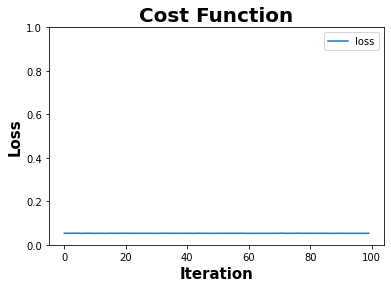

933/933 [==============================] - 0s 433us/step
TN, FP, FN, TP: 28411 20 118 1304
Accuracy = 0.9953773490101497
Precesion = 0.9848942598187311
Recall = 0.9170182841068917
F1 = 0.9497450837581938
F0.5 = 0.9705269425424234
F2 = 0.9298345693097546
Gmean = 0.9572738378975924
Balanced Accu. = 0.9581574133066554
################################################## 10th CV ##################################################


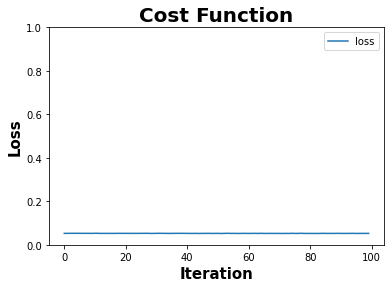

933/933 [==============================] - 0s 437us/step
TN, FP, FN, TP: 28400 31 114 1308
Accuracy = 0.9951428667135631
Precesion = 0.9768483943241225
Recall = 0.919831223628692
F1 = 0.9474827960883738
F0.5 = 0.9648863971673061
F2 = 0.9306958872918741
Gmean = 0.9585553073608744
Balanced Accu. = 0.9593704322568207


In [180]:
f1_acc = []
f1_f1 = []
f1_f5 = []
f1_f2 = []
f1_gmean = []
f1_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  
print('batch_size: ', batch_size)
learning_rate=0.01

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_card, df_card.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'f1_score', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    f1_acc.append((TP+TN)/(TP+TN+FP+FN))
    f1_f1.append(TP / (TP + 0.5*(FP+FN)))
    f1_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    f1_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    f1_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    f1_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [181]:
res['F1Aim'] = [np.mean(f1_acc), np.mean(f1_f1), np.mean(f1_f5), np.mean(f1_f2), np.mean(f1_gmean), np.mean(f1_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.992095,0.994868,0,0,0,0.982049
F1,0,0,0.910032,0.944155,0,0,0,0.830703
F.5,0,0,0.958161,0.964592,0,0,0,0.784658
F2,0,0,0.866519,0.924656,0,0,0,0.882952
Gmean,0,0,0.916242,0.954546,0,0,0,0.952943
B_Acc,0,0,0.919734,0.955573,0,0,0,0.953487


batch_size:  134338
################################################## 1th CV ##################################################


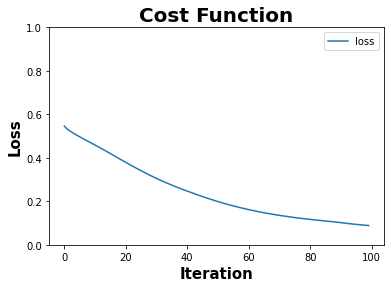

933/933 [==============================] - 0s 434us/step
TN, FP, FN, TP: 28019 413 202 1220
Accuracy = 0.9793997454277483
Precesion = 0.747091243110839
Recall = 0.8579465541490858
F1 = 0.7986906710310966
F0.5 = 0.7669097309529795
F2 = 0.8332195055320313
Gmean = 0.9195021044186693
Balanced Accu. = 0.9217103339119093
################################################## 2th CV ##################################################


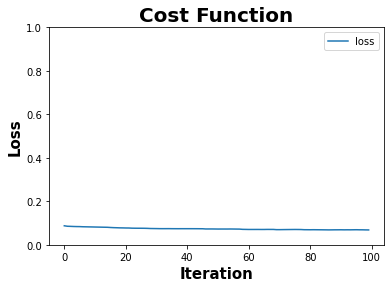

933/933 [==============================] - 0s 454us/step
TN, FP, FN, TP: 28046 386 143 1278
Accuracy = 0.9822798378722406
Precesion = 0.7680288461538461
Recall = 0.8993666432090077
F1 = 0.8285251215559157
F0.5 = 0.7911353225207379
F2 = 0.8696243875884594
Gmean = 0.9418899165620203
Balanced Accu. = 0.9428951955493547
################################################## 3th CV ##################################################


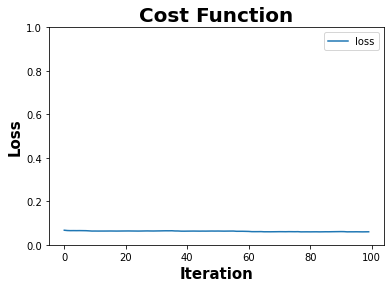

933/933 [==============================] - 0s 440us/step
TN, FP, FN, TP: 27973 459 134 1287
Accuracy = 0.9801359997320203
Precesion = 0.7371134020618557
Recall = 0.9057002111189303
F1 = 0.8127565519419009
F0.5 = 0.7656157049375372
F2 = 0.8660834454912517
Gmean = 0.9439696947816786
Balanced Accu. = 0.9447782147322282
################################################## 4th CV ##################################################


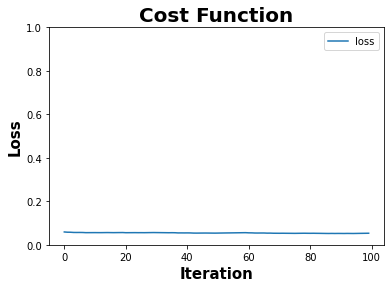

933/933 [==============================] - 0s 434us/step
TN, FP, FN, TP: 27939 493 119 1302
Accuracy = 0.9794995477841423
Precesion = 0.7253481894150418
Recall = 0.916256157635468
F1 = 0.8097014925373134
F0.5 = 0.7568887338681548
F2 = 0.870437224227838
Gmean = 0.9488775613763064
Balanced Accu. = 0.9494582701514425
################################################## 5th CV ##################################################


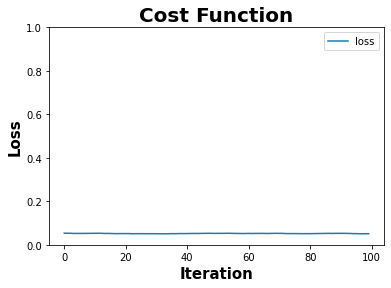

933/933 [==============================] - 0s 459us/step
TN, FP, FN, TP: 27978 454 103 1318
Accuracy = 0.9813419086858942
Precesion = 0.7437923250564334
Recall = 0.9275158339197748
F1 = 0.8255559035389916
F0.5 = 0.7744740862616054
F2 = 0.8838519313304721
Gmean = 0.955356128399123
Balanced Accu. = 0.9557739552266291
################################################## 6th CV ##################################################


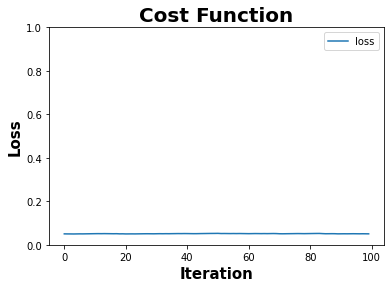

933/933 [==============================] - 0s 469us/step
TN, FP, FN, TP: 27970 461 103 1319
Accuracy = 0.9811074263893076
Precesion = 0.7410112359550561
Recall = 0.9275668073136427
F1 = 0.8238600874453467
F0.5 = 0.7720674315148678
F2 = 0.8831012319228708
Gmean = 0.9552625786820776
Balanced Accu. = 0.9556760560433009
################################################## 7th CV ##################################################


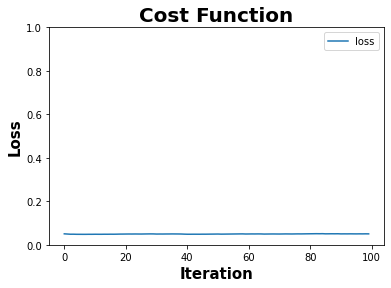

933/933 [==============================] - 0s 452us/step
TN, FP, FN, TP: 27948 483 94 1328
Accuracy = 0.9806719592670753
Precesion = 0.7332965212589729
Recall = 0.9338959212376934
F1 = 0.8215279925765543
F0.5 = 0.7662127855988922
F2 = 0.8854513935191359
Gmean = 0.95813904617682
Balanced Accu. = 0.9584537113838567
################################################## 8th CV ##################################################


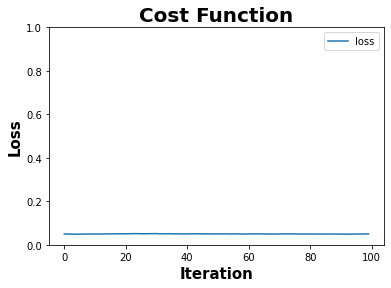

933/933 [==============================] - 0s 440us/step
TN, FP, FN, TP: 27963 468 96 1326
Accuracy = 0.9811074263893076
Precesion = 0.7391304347826086
Recall = 0.9324894514767933
F1 = 0.8246268656716418
F0.5 = 0.771109560362875
F2 = 0.8861267040898156
Gmean = 0.9576741778268599
Balanced Accu. = 0.9580142730634995
################################################## 9th CV ##################################################


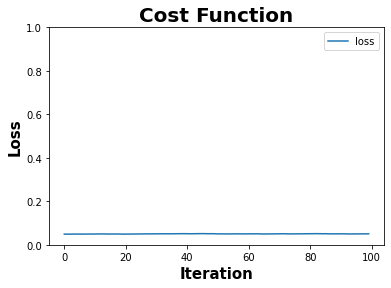

933/933 [==============================] - 0s 431us/step
TN, FP, FN, TP: 27968 463 104 1318
Accuracy = 0.9810069339764848
Precesion = 0.7400336889387984
Recall = 0.9268635724331927
F1 = 0.82297845769591
F0.5 = 0.7711209922770886
F2 = 0.8823135627259339
Gmean = 0.9548662530305417
Balanced Accu. = 0.9552892657283969
################################################## 10th CV ##################################################


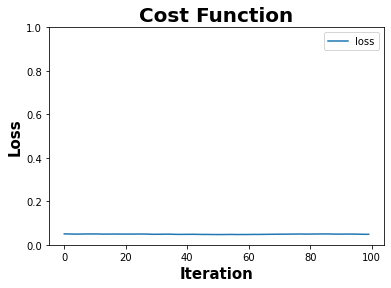

933/933 [==============================] - 0s 451us/step
TN, FP, FN, TP: 28059 372 114 1308
Accuracy = 0.9837202291227012
Precesion = 0.7785714285714286
Recall = 0.919831223628692
F1 = 0.8433268858800773
F0.5 = 0.8032424465733236
F2 = 0.8876221498371335
Gmean = 0.9527832215781263
Balanced Accu. = 0.9533734571240431


In [182]:
bacc_acc = []
bacc_f1 = []
bacc_f5 = []
bacc_f2 = []
bacc_gmean = []
bacc_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.5)  
print('batch_size: ', batch_size)
learning_rate=0.005

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_card, df_card.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'bacc', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    bacc_acc.append((TP+TN)/(TP+TN+FP+FN))
    bacc_f1.append(TP / (TP + 0.5*(FP+FN)))
    bacc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    bacc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    bacc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    bacc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [183]:
res['BAim'] = [np.mean(bacc_acc), np.mean(bacc_f1), np.mean(bacc_f5), np.mean(bacc_f2), np.mean(bacc_gmean), np.mean(bacc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.992095,0.994868,0,0,0,0.981027
F1,0,0,0.910032,0.944155,0,0,0,0.821155
F.5,0,0,0.958161,0.964592,0,0,0,0.773878
F2,0,0,0.866519,0.924656,0,0,0,0.874783
Gmean,0,0,0.916242,0.954546,0,0,0,0.948832
B_Acc,0,0,0.919734,0.955573,0,0,0,0.949542


# 3. Breast Cancer Data (30d / 569)

In [69]:
# class 'B' = Benign, class 'M' = Malignant
cancer_df = pd.read_csv('breast_cancer.csv')
cancer_df.shape

(569, 32)

In [70]:
cancer_df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [71]:
cancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [72]:
cancer_df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [73]:
# M/Malignant = 0, B/Benign = 1
y_encoded, y_class = pd.factorize(cancer_df['diagnosis'])
print(y_class)
y_encoded

Index(['M', 'B'], dtype='object')


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [74]:
# But I want [B/Benign = 0(Major), M/Malignant = 1(minor)]
y_encoded = (y_encoded+1)%2
y_encoded

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

In [75]:
cancer_df['label'] = y_encoded
cancer_df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [76]:
cancer_df = cancer_df.drop('id', axis=1)
cancer_df = cancer_df.drop('diagnosis', axis=1)
cancer_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [77]:
# Amount values largely varies.

# # Normalization
# card_df.iloc[:,:-1] = (card_df.iloc[:,:-1] - card_df.iloc[:,:-1].min())/(card_df.iloc[:,:-1].max() - card_df.iloc[:,:-1].min())

# Standardization
cancer_df.iloc[:,:-1] = (cancer_df.iloc[:,:-1] - cancer_df.iloc[:,:-1].mean())/cancer_df.iloc[:,:-1].std()

cancer_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764,...,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312,1
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889,...,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943,1
2,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658,...,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214,1
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602,...,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672,1
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956,...,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.109139,0.720838,2.058974,2.341795,1.040926,0.218868,1.945573,2.318924,-0.312314,-0.930209,...,0.117596,1.751022,2.013529,0.378033,-0.273077,0.663928,1.627719,-1.358963,-0.708467,1
565,1.703356,2.083301,1.614511,1.722326,0.102368,-0.017817,0.692434,1.262558,-0.217473,-1.057681,...,2.045599,1.420690,1.493644,-0.690623,-0.394473,0.236365,0.733182,-0.531387,-0.973122,1
566,0.701667,2.043775,0.672084,0.577445,-0.839745,-0.038646,0.046547,0.105684,-0.808406,-0.894800,...,1.373645,0.578492,0.427529,-0.808876,0.350427,0.326479,0.413705,-1.103578,-0.318129,1
567,1.836725,2.334403,1.980781,1.733693,1.524426,3.269267,3.294046,2.656528,2.135315,1.042778,...,2.235958,2.301575,1.651717,1.429169,3.901415,3.194794,2.287972,1.917396,2.217684,1


In [78]:
cancer_df['label'].value_counts()

0    357
1    212
Name: label, dtype: int64

In [79]:
# Data is too balanced!!! We intentionally make it imbalanced.
df_0 = cancer_df[cancer_df['label']==0]
df_1 = cancer_df[cancer_df['label']==1]
print(len(df_0), len(df_1))

357 212


In [80]:
N = round(len(df_0)*0.1)
df_1_samp = df_1.sample(n=N, random_state = 100)
df_1_samp

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
219,1.533097,3.064460,1.482818,1.614345,-0.864631,0.163957,0.322388,0.449731,-1.399339,-1.369279,...,3.210535,2.170633,2.803894,0.369273,0.987914,0.610243,0.728618,-0.303481,-0.457654,1
45,1.283384,-0.392847,1.305856,1.196630,0.962713,1.216733,1.362280,1.339615,0.347926,-0.326840,...,-0.708923,1.289747,1.205600,1.556182,1.619046,2.216001,1.874173,1.451885,0.437632,1
408,1.096100,0.318610,1.063047,0.957083,0.514765,0.493423,0.392634,1.013350,0.657983,-0.298513,...,-0.043477,0.917752,0.822712,0.693374,0.757834,0.277588,1.259559,0.257396,0.060028,1
156,1.008133,0.337210,1.046586,0.877518,1.076478,1.176970,1.213007,1.455585,0.581381,-0.161126,...,-0.092288,0.763001,0.740163,0.413071,0.607202,0.412759,0.561273,-0.707570,-0.363530,1
213,0.934354,1.457870,0.927239,0.832905,0.301456,0.194253,0.995997,0.439423,-1.837067,-0.586034,...,0.389306,0.391006,0.246624,-0.353383,-0.476463,0.038881,-0.071597,-2.097638,-0.872908,1
100,-0.146789,1.323019,-0.161284,-0.205133,-0.105252,-0.364135,-0.031978,-0.103836,-0.739099,-0.578952,...,1.560751,0.039842,0.045520,-0.257029,-0.381126,0.214316,0.057716,-0.403695,-0.552332,1
372,2.055224,-0.974102,2.030166,2.077526,0.265905,0.892947,1.309595,1.973589,0.588676,-0.137048,...,-0.624319,1.334387,1.149396,-0.576750,0.188990,0.624144,1.247389,-0.276002,0.150276,1
212,3.967796,-0.190570,3.972634,5.240230,1.268455,0.894841,2.901420,2.849813,-0.596837,-1.069012,...,-1.172620,2.417638,2.842534,-0.795736,-0.652519,0.229655,0.682979,-2.024902,-1.588804,1
433,1.331624,0.623187,1.305856,1.293244,0.386780,0.654369,0.885610,0.992733,0.479244,-0.209282,...,0.854630,1.132021,1.268829,0.290438,0.584956,0.570459,0.854888,0.171729,-0.044616,1
365,1.791323,0.579012,1.721511,1.813257,-0.345580,0.165850,0.115287,0.745586,-0.706269,-1.023688,...,0.112715,1.605200,1.579706,0.014515,-0.105920,-0.009531,0.941603,-0.471582,-0.918862,1


In [81]:
cancer_df = concath(df_0, df_1_samp)
cancer_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
19,-0.166653,-1.146154,-0.185565,-0.251735,0.101657,-0.436466,-0.277965,-0.028584,0.267676,-0.727669,...,-1.044086,-0.225019,-0.297499,0.509425,-0.489175,-0.159083,0.215933,0.123238,-0.628739,0
20,-0.297184,-0.832276,-0.260877,-0.383301,0.792066,0.429044,-0.540886,-0.459223,0.566790,0.752425,...,-0.843964,-0.332451,-0.439238,-0.051181,0.148312,-0.398748,-0.635551,0.457824,-0.117147,0
21,-1.311926,-1.592558,-1.301661,-1.082620,0.429441,-0.746429,-0.743094,-0.725698,0.012334,0.885562,...,-1.629809,-1.253810,-0.993547,0.001375,-0.886413,-0.879660,-0.796202,-0.728583,-0.344152,0
37,-0.311372,-0.202195,-0.385162,-0.372503,-0.464322,-1.262592,-0.792517,-0.507415,-1.257077,-0.590283,...,-0.466499,-0.678556,-0.587827,-1.548613,-1.322484,-1.073022,-0.980890,-1.476957,-1.232240,0
46,-1.683090,-0.569549,-1.656820,-1.287215,-0.736646,-0.850381,-0.914695,-1.108221,-0.155461,0.316186,...,-0.604795,-1.488019,-1.121235,-0.116877,-0.753576,-0.974903,-1.353462,0.330132,-0.545688,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.117112,1.918224,0.195933,0.011113,1.247125,1.044426,0.942058,0.637089,1.792428,1.129176,...,1.863374,0.501116,0.109978,1.551802,2.564154,2.063094,0.860973,2.129139,2.776892,1
489,0.727206,0.211659,0.622700,0.576024,-1.520911,-0.629033,-0.656165,-0.666166,0.125414,-1.352283,...,0.143628,0.596347,0.357275,-1.378241,0.239836,-0.117381,-0.414350,2.871047,-0.427202,1
451,1.550123,1.327669,1.470472,1.523414,0.486324,-0.106622,0.962128,1.074943,-0.542121,-1.258804,...,0.859511,0.968343,0.949171,0.894842,-0.443413,0.601615,0.486728,-0.982351,-1.275426,1
223,0.460467,0.223284,0.437507,0.302377,0.436552,0.304075,0.324896,0.404632,0.450062,0.032915,...,0.750502,0.554684,0.364300,0.999955,1.231342,0.601136,0.506505,1.765458,1.243223,1


In [82]:
cancer_df['label'].value_counts()

0    357
1     36
Name: label, dtype: int64

In [83]:
res = pd.DataFrame({'Delta':[0, 0, 0, 0, 0, 0],
                    'BCE':[0, 0, 0, 0, 0, 0],
                    'AccAim':[0, 0, 0, 0, 0, 0],
                    'F1Aim':[0, 0, 0, 0, 0, 0],
                    'F.5Aim':[0, 0, 0, 0, 0, 0],
                    'F2Aim':[0, 0, 0, 0, 0, 0],
                    'GAim':[0, 0, 0, 0, 0, 0],
                    'BAim':[0, 0, 0, 0, 0, 0]}, index = ['Acc','F1','F.5','F2','Gmean','B_Acc'])

In [84]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2)

X = cancer_df.iloc[:, :-1]
y = cancer_df.iloc[:, -1]

In [85]:
L = 73
hidden_node = 2
# momentum=0.9
activation = 'sigmoid'  
kernel_initializer=keras.initializers.he_normal(seed=100)
epochs=100

batch_size:  17
################################################## 1th CV ##################################################


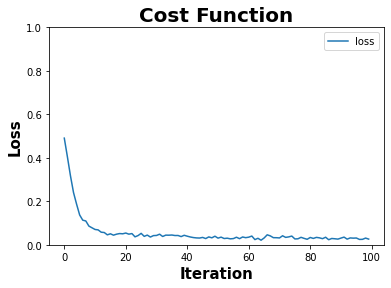

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 2th CV ##################################################


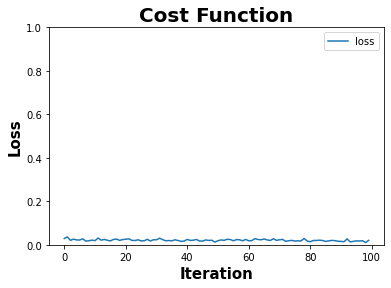

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 1 3
Accuracy = 0.975
Precesion = 1.0
Recall = 0.75
F1 = 0.8571428571428571
F0.5 = 0.9375
F2 = 0.7894736842105263
Gmean = 0.8660254037844386
Balanced Accu. = 0.875
################################################## 3th CV ##################################################


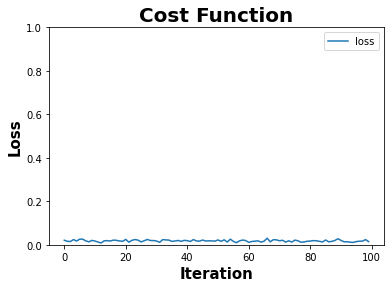

2/2 [==============================] - 0s 2ms/step
TN, FP, FN, TP: 36 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 4th CV ##################################################


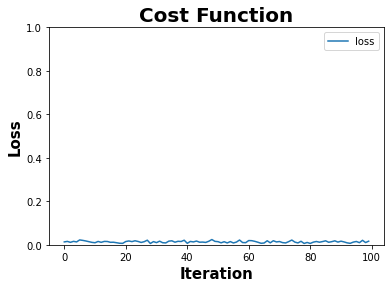

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 1 2
Accuracy = 0.9743589743589743
Precesion = 1.0
Recall = 0.6666666666666666
F1 = 0.8
F0.5 = 0.9090909090909091
F2 = 0.7142857142857143
Gmean = 0.816496580927726
Balanced Accu. = 0.8333333333333333
################################################## 5th CV ##################################################


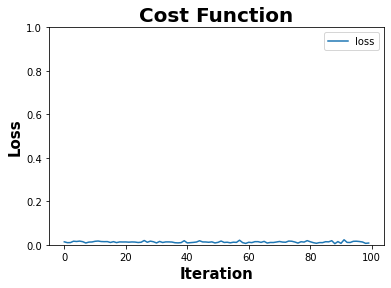

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 6th CV ##################################################


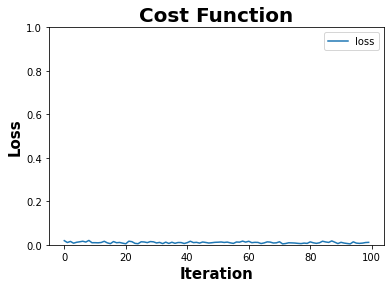

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 2 1
Accuracy = 0.9487179487179487
Precesion = 1.0
Recall = 0.3333333333333333
F1 = 0.5
F0.5 = 0.7142857142857143
F2 = 0.3846153846153846
Gmean = 0.5773502691896257
Balanced Accu. = 0.6666666666666666
################################################## 7th CV ##################################################


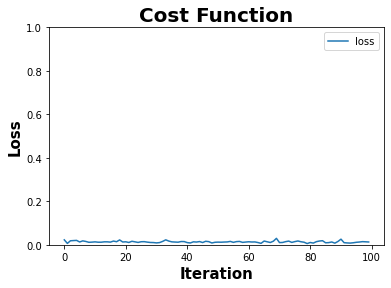

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 8th CV ##################################################


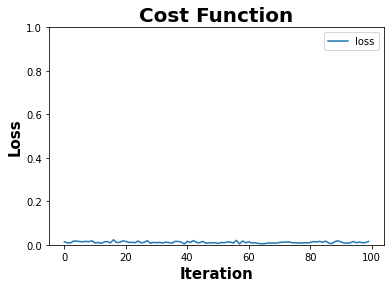

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 34 1 0 4
Accuracy = 0.9743589743589743
Precesion = 0.8
Recall = 1.0
F1 = 0.8888888888888888
F0.5 = 0.8333333333333334
F2 = 0.9523809523809523
Gmean = 0.9856107606091623
Balanced Accu. = 0.9857142857142858
################################################## 9th CV ##################################################


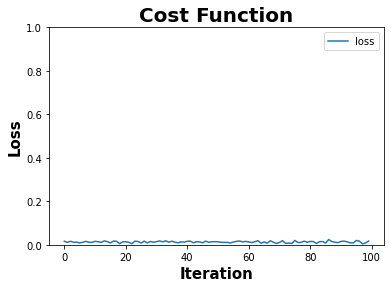

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 10th CV ##################################################


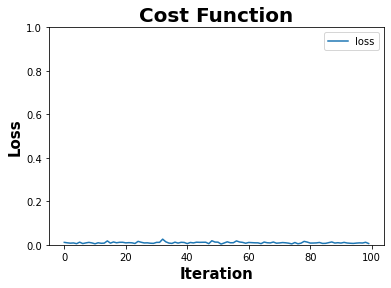

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 0 1 3
Accuracy = 0.9743589743589743
Precesion = 1.0
Recall = 0.75
F1 = 0.8571428571428571
F0.5 = 0.9375
F2 = 0.7894736842105263
Gmean = 0.8660254037844386
Balanced Accu. = 0.875


In [98]:
acc_acc = []
acc_f1 = []
acc_f5 = []
acc_f2 = []
acc_gmean = []
acc_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  
print('batch_size: ', batch_size)
learning_rate=0.001

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(cancer_df, cancer_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'accuracy', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    acc_acc.append((TP+TN)/(TP+TN+FP+FN))
    acc_f1.append(TP / (TP + 0.5*(FP+FN)))
    acc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    acc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    acc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    acc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [99]:
res['AccAim'] = [np.mean(acc_acc), np.mean(acc_f1), np.mean(acc_f5), np.mean(acc_f2), np.mean(acc_gmean), np.mean(acc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.984679,0,0,0,0,0
F1,0,0,0.890317,0,0,0,0,0
F.5,0,0,0.933171,0,0,0,0,0
F2,0,0,0.863023,0,0,0,0,0
Gmean,0,0,0.911151,0,0,0,0,0
B_Acc,0,0,0.923571,0,0,0,0,0


batch_size:  17
################################################## 1th CV ##################################################


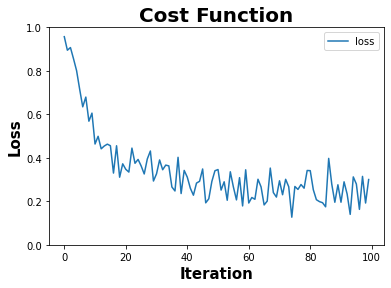

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 2th CV ##################################################


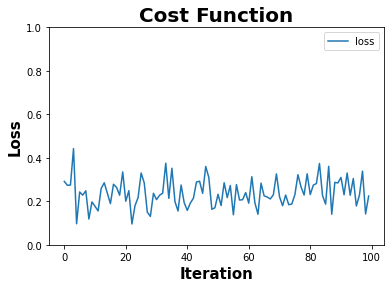

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 1 3
Accuracy = 0.975
Precesion = 1.0
Recall = 0.75
F1 = 0.8571428571428571
F0.5 = 0.9375
F2 = 0.7894736842105263
Gmean = 0.8660254037844386
Balanced Accu. = 0.875
################################################## 3th CV ##################################################


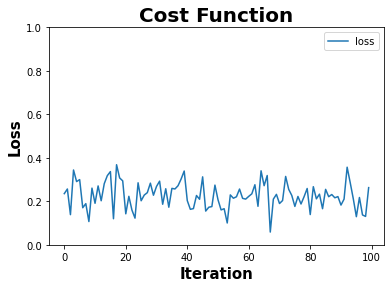

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 4th CV ##################################################


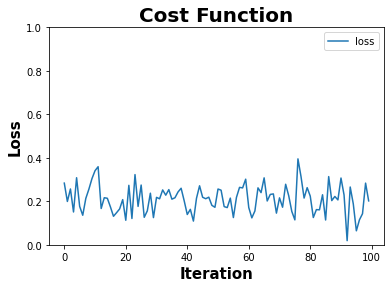

2/2 [==============================] - 0s 2ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 5th CV ##################################################


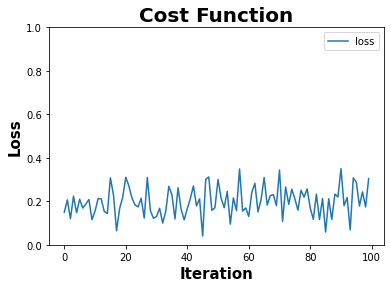

2/2 [==============================] - 0s 2ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 6th CV ##################################################


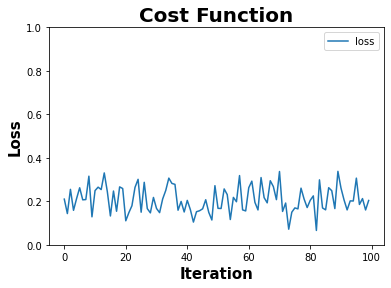

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 1 2
Accuracy = 0.9743589743589743
Precesion = 1.0
Recall = 0.6666666666666666
F1 = 0.8
F0.5 = 0.9090909090909091
F2 = 0.7142857142857143
Gmean = 0.816496580927726
Balanced Accu. = 0.8333333333333333
################################################## 7th CV ##################################################


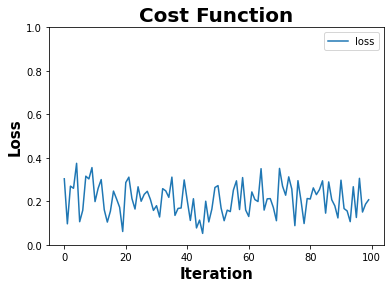

2/2 [==============================] - 0s 2ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 8th CV ##################################################


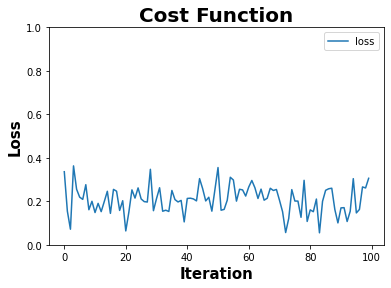

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 34 1 0 4
Accuracy = 0.9743589743589743
Precesion = 0.8
Recall = 1.0
F1 = 0.8888888888888888
F0.5 = 0.8333333333333334
F2 = 0.9523809523809523
Gmean = 0.9856107606091623
Balanced Accu. = 0.9857142857142858
################################################## 9th CV ##################################################


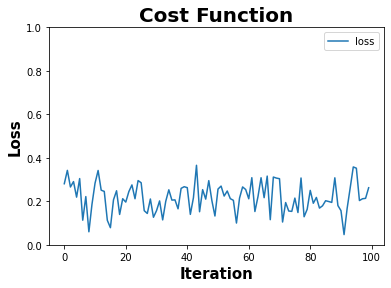

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 10th CV ##################################################


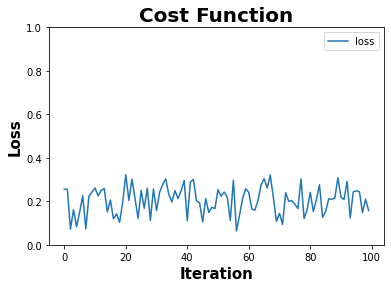

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0


In [106]:
f1_acc = []
f1_f1 = []
f1_f5 = []
f1_f2 = []
f1_gmean = []
f1_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  
print('batch_size: ', batch_size)
learning_rate=0.01

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(cancer_df, cancer_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'f1_score', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    f1_acc.append((TP+TN)/(TP+TN+FP+FN))
    f1_f1.append(TP / (TP + 0.5*(FP+FN)))
    f1_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    f1_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    f1_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    f1_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [107]:
res['F1Aim'] = [np.mean(f1_acc), np.mean(f1_f1), np.mean(f1_f5), np.mean(f1_f2), np.mean(f1_gmean), np.mean(f1_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.984679,0.992372,0,0,0,0
F1,0,0,0.890317,0.954603,0,0,0,0
F.5,0,0,0.933171,0.967992,0,0,0,0
F2,0,0,0.863023,0.945614,0,0,0,0
Gmean,0,0,0.911151,0.966813,0,0,0,0
B_Acc,0,0,0.923571,0.969405,0,0,0,0


batch_size:  176
################################################## 1th CV ##################################################


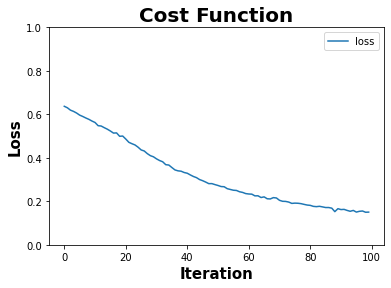

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 1 0 4
Accuracy = 0.975
Precesion = 0.8
Recall = 1.0
F1 = 0.8888888888888888
F0.5 = 0.8333333333333334
F2 = 0.9523809523809523
Gmean = 0.9860132971832694
Balanced Accu. = 0.9861111111111112
################################################## 2th CV ##################################################


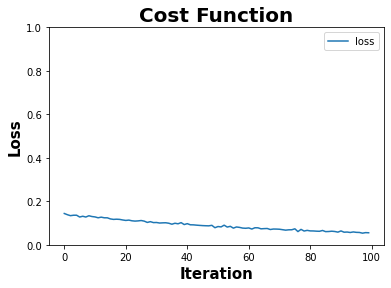

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 3th CV ##################################################


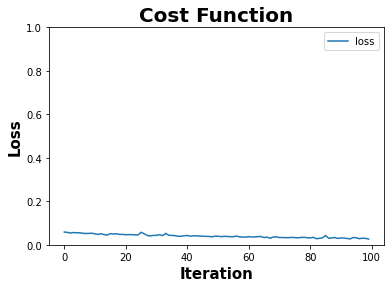

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 1 0 4
Accuracy = 0.975
Precesion = 0.8
Recall = 1.0
F1 = 0.8888888888888888
F0.5 = 0.8333333333333334
F2 = 0.9523809523809523
Gmean = 0.9860132971832694
Balanced Accu. = 0.9861111111111112
################################################## 4th CV ##################################################


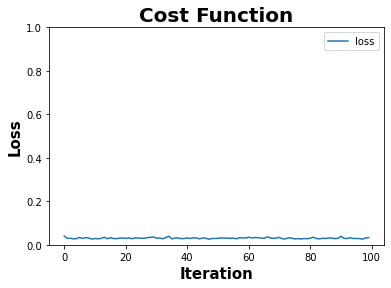

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 5th CV ##################################################


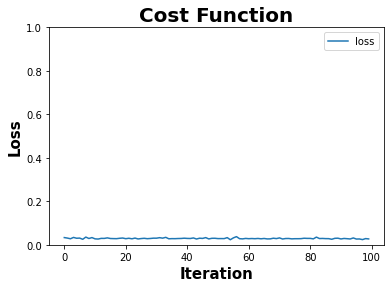

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 1 0 3
Accuracy = 0.9743589743589743
Precesion = 0.75
Recall = 1.0
F1 = 0.8571428571428571
F0.5 = 0.7894736842105263
F2 = 0.9375
Gmean = 0.9860132971832694
Balanced Accu. = 0.9861111111111112
################################################## 6th CV ##################################################


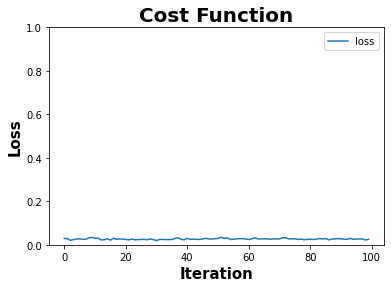

2/2 [==============================] - 0s 2ms/step
TN, FP, FN, TP: 36 0 1 2
Accuracy = 0.9743589743589743
Precesion = 1.0
Recall = 0.6666666666666666
F1 = 0.8
F0.5 = 0.9090909090909091
F2 = 0.7142857142857143
Gmean = 0.816496580927726
Balanced Accu. = 0.8333333333333333
################################################## 7th CV ##################################################


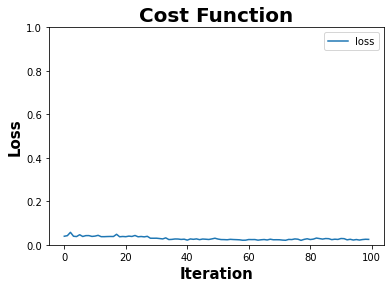

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 1 0 3
Accuracy = 0.9743589743589743
Precesion = 0.75
Recall = 1.0
F1 = 0.8571428571428571
F0.5 = 0.7894736842105263
F2 = 0.9375
Gmean = 0.9860132971832694
Balanced Accu. = 0.9861111111111112
################################################## 8th CV ##################################################


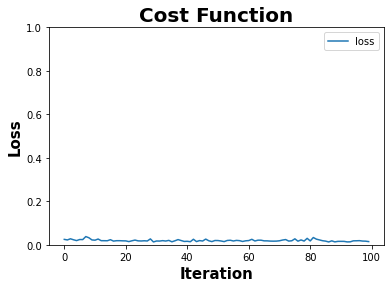

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 34 1 0 4
Accuracy = 0.9743589743589743
Precesion = 0.8
Recall = 1.0
F1 = 0.8888888888888888
F0.5 = 0.8333333333333334
F2 = 0.9523809523809523
Gmean = 0.9856107606091623
Balanced Accu. = 0.9857142857142858
################################################## 9th CV ##################################################


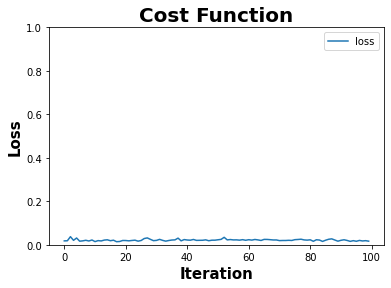

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 10th CV ##################################################


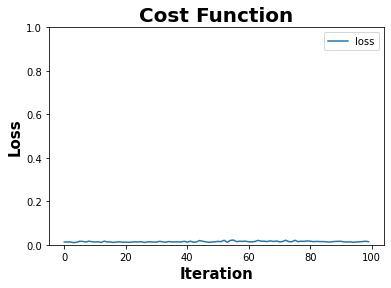

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 34 1 0 4
Accuracy = 0.9743589743589743
Precesion = 0.8
Recall = 1.0
F1 = 0.8888888888888888
F0.5 = 0.8333333333333334
F2 = 0.9523809523809523
Gmean = 0.9856107606091623
Balanced Accu. = 0.9857142857142858


In [108]:
bacc_acc = []
bacc_f1 = []
bacc_f5 = []
bacc_f2 = []
bacc_gmean = []
bacc_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.5)  
print('batch_size: ', batch_size)
learning_rate=0.005

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(cancer_df, cancer_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'bacc', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    bacc_acc.append((TP+TN)/(TP+TN+FP+FN))
    bacc_f1.append(TP / (TP + 0.5*(FP+FN)))
    bacc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    bacc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    bacc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    bacc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [109]:
res['BAim'] = [np.mean(bacc_acc), np.mean(bacc_f1), np.mean(bacc_f5), np.mean(bacc_f2), np.mean(bacc_gmean), np.mean(bacc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.984679,0.992372,0,0,0,0.982179
F1,0,0,0.890317,0.954603,0,0,0,0.906984
F.5,0,0,0.933171,0.967992,0,0,0,0.882137
F2,0,0,0.863023,0.945614,0,0,0,0.939881
Gmean,0,0,0.911151,0.966813,0,0,0,0.973177
B_Acc,0,0,0.923571,0.969405,0,0,0,0.974921


# 4. Diabetes Prediction Data (8d / 100000)

In [127]:
# class 'B' = Benign, class 'M' = Malignant
diab_df = pd.read_csv('diabetes_prediction_dataset.csv')
diab_df.shape

(100000, 9)

In [128]:
diab_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [129]:
diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [130]:
# Female = 0, Male = 1, other = 2
gen_encoded, gen_class = pd.factorize(diab_df['gender'])
print(gen_class)
gen_encoded

Index(['Female', 'Male', 'Other'], dtype='object')


array([0, 0, 1, ..., 1, 0, 0])

In [131]:
# Female = 0, Male = 1, other = 2
pd.Series(gen_encoded).value_counts()

0    58552
1    41430
2       18
dtype: int64

In [132]:
diab_df['gender'] = gen_encoded
diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,never,25.19,6.6,140,0
1,0,54.0,0,0,No Info,27.32,6.6,80,0
2,1,28.0,0,0,never,27.32,5.7,158,0
3,0,36.0,0,0,current,23.45,5.0,155,0
4,1,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,No Info,27.32,6.2,90,0
99996,0,2.0,0,0,No Info,17.37,6.5,100,0
99997,1,66.0,0,0,former,27.83,5.7,155,0
99998,0,24.0,0,0,never,35.42,4.0,100,0


In [133]:
# never = 0, Info = 1, current = 2, former=3, ever=4, not current=5
smo_encoded, smo_class = pd.factorize(diab_df['smoking_history'])
print(smo_class)
smo_encoded

Index(['never', 'No Info', 'current', 'former', 'ever', 'not current'], dtype='object')


array([0, 1, 0, ..., 3, 0, 2])

In [134]:
# never = 0, Info = 1, current = 2, former=3, ever=4, not current=5
pd.Series(smo_encoded).value_counts()

1    35816
0    35095
3     9352
2     9286
5     6447
4     4004
dtype: int64

In [135]:
diab_df['smoking_history'] = smo_encoded
diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,0,25.19,6.6,140,0
1,0,54.0,0,0,1,27.32,6.6,80,0
2,1,28.0,0,0,0,27.32,5.7,158,0
3,0,36.0,0,0,2,23.45,5.0,155,0
4,1,76.0,1,1,2,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,1,27.32,6.2,90,0
99996,0,2.0,0,0,1,17.37,6.5,100,0
99997,1,66.0,0,0,3,27.83,5.7,155,0
99998,0,24.0,0,0,0,35.42,4.0,100,0


In [136]:
diab_df.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.414660,41.885856,0.07485,0.039420,1.306950,27.320767,5.527507,138.058060,0.085000
std,0.493031,22.516840,0.26315,0.194593,1.454501,6.636783,1.070672,40.708136,0.278883
min,0.000000,0.080000,0.00000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,24.000000,0.00000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,0.000000,43.000000,0.00000,0.000000,1.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,60.000000,0.00000,0.000000,2.000000,29.580000,6.200000,159.000000,0.000000
max,2.000000,80.000000,1.00000,1.000000,5.000000,95.690000,9.000000,300.000000,1.000000


In [137]:
# Amount values largely varies.

# # Normalization
# card_df.iloc[:,:-1] = (card_df.iloc[:,:-1] - card_df.iloc[:,:-1].min())/(card_df.iloc[:,:-1].max() - card_df.iloc[:,:-1].min())

# Standardization
diab_df.iloc[:,:-1] = (diab_df.iloc[:,:-1] - diab_df.iloc[:,:-1].mean())/diab_df.iloc[:,:-1].std()

diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,-0.841043,1.692695,-0.284438,4.936354,-0.898556,-0.321054,1.001701,0.047704,0
1,-0.841043,0.538004,-0.284438,-0.202577,-0.211035,-0.000116,1.001701,-1.426203,0
2,1.187228,-0.616688,-0.284438,-0.202577,-0.898556,-0.000116,0.161107,0.489876,0
3,-0.841043,-0.261398,-0.284438,-0.202577,0.476486,-0.583229,-0.492688,0.416181,0
4,1.187228,1.515050,3.515669,4.936354,0.476486,-1.081965,-0.679486,0.416181,0
...,...,...,...,...,...,...,...,...,...
99995,-0.841043,1.692695,-0.284438,-0.202577,-0.211035,-0.000116,0.628104,-1.180552,0
99996,-0.841043,-1.771379,-0.284438,-0.202577,-0.211035,-1.499336,0.908301,-0.934901,0
99997,1.187228,1.070938,-0.284438,-0.202577,1.164008,0.076729,0.161107,0.416181,0
99998,-0.841043,-0.794332,-0.284438,-0.202577,-0.898556,1.220355,-1.426681,-0.934901,0


In [138]:
res = pd.DataFrame({'Delta':[0, 0, 0, 0, 0, 0],
                    'BCE':[0, 0, 0, 0, 0, 0],
                    'AccAim':[0, 0, 0, 0, 0, 0],
                    'F1Aim':[0, 0, 0, 0, 0, 0],
                    'F.5Aim':[0, 0, 0, 0, 0, 0],
                    'F2Aim':[0, 0, 0, 0, 0, 0],
                    'GAim':[0, 0, 0, 0, 0, 0],
                    'BAim':[0, 0, 0, 0, 0, 0]}, index = ['Acc','F1','F.5','F2','Gmean','B_Acc'])

In [139]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2)

X = diab_df.iloc[:, :-1]
y = diab_df.iloc[:, -1]

In [140]:
L = 73
hidden_node = 2
# momentum=0.9
activation = 'sigmoid'  
kernel_initializer=keras.initializers.he_normal(seed=100)
epochs=100

batch_size:  4500
################################################## 1th CV ##################################################


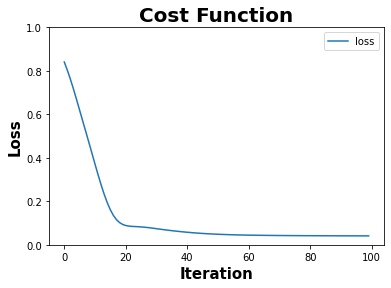

313/313 [==============================] - 0s 449us/step
TN, FP, FN, TP: 9104 46 347 503
Accuracy = 0.9607
Precesion = 0.9162112932604736
Recall = 0.591764705882353
F1 = 0.7190850607576841
F0.5 = 0.8256730137885753
F2 = 0.6368700936946061
Gmean = 0.7673263412123646
Balanced Accu. = 0.7933686917389907
################################################## 2th CV ##################################################


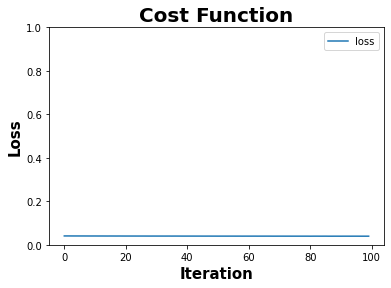

313/313 [==============================] - 0s 472us/step
TN, FP, FN, TP: 9088 62 344 506
Accuracy = 0.9594
Precesion = 0.8908450704225352
Recall = 0.5952941176470589
F1 = 0.7136812411847673
F0.5 = 0.8103779628443306
F2 = 0.637600806451613
Gmean = 0.7689346075770481
Balanced Accu. = 0.7942590806814529
################################################## 3th CV ##################################################


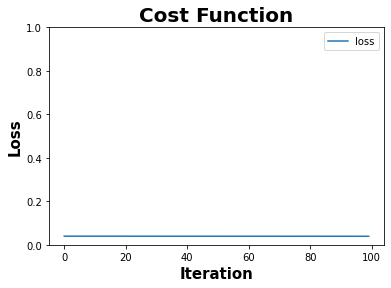

313/313 [==============================] - 0s 461us/step
TN, FP, FN, TP: 9103 47 359 491
Accuracy = 0.9594
Precesion = 0.912639405204461
Recall = 0.5776470588235294
F1 = 0.707492795389049
F0.5 = 0.8177881412391739
F2 = 0.6234128999492129
Gmean = 0.7580764539258462
Balanced Accu. = 0.7862552234008358
################################################## 4th CV ##################################################


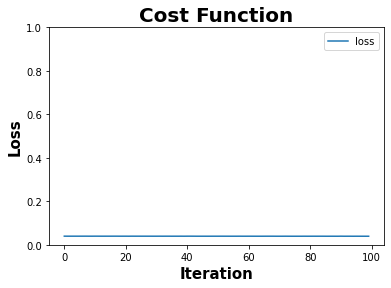

313/313 [==============================] - 0s 440us/step
TN, FP, FN, TP: 9110 40 327 523
Accuracy = 0.9633
Precesion = 0.9289520426287744
Recall = 0.6152941176470588
F1 = 0.7402689313517339
F0.5 = 0.8430045132172792
F2 = 0.6598536462276053
Gmean = 0.7826904287754445
Balanced Accu. = 0.8054612664738026
################################################## 5th CV ##################################################


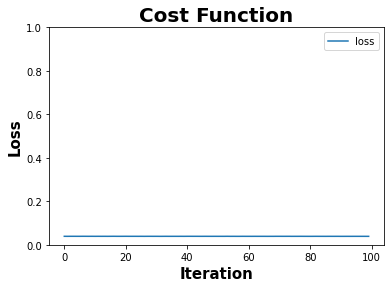

313/313 [==============================] - 0s 450us/step
TN, FP, FN, TP: 9094 56 343 507
Accuracy = 0.9601
Precesion = 0.9005328596802842
Recall = 0.5964705882352941
F1 = 0.7176220806794055
F0.5 = 0.8172147001934237
F2 = 0.6396669190007569
Gmean = 0.7699480877690451
Balanced Accu. = 0.7951751848280295
################################################## 6th CV ##################################################


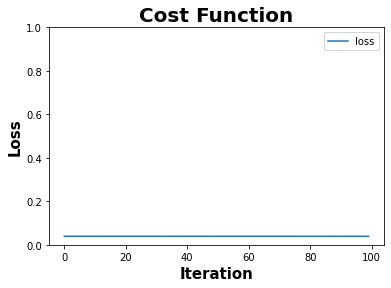

313/313 [==============================] - 0s 454us/step
TN, FP, FN, TP: 9098 52 316 534
Accuracy = 0.9632
Precesion = 0.9112627986348123
Recall = 0.6282352941176471
F1 = 0.7437325905292479
F0.5 = 0.8359423919849718
F2 = 0.669844455594581
Gmean = 0.7903575109900577
Balanced Accu. = 0.8112761170041787
################################################## 7th CV ##################################################


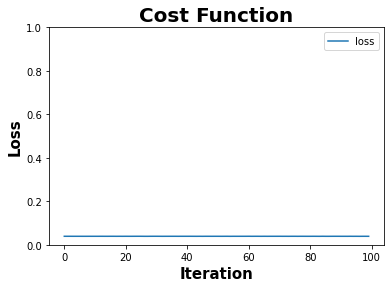

313/313 [==============================] - 0s 447us/step
TN, FP, FN, TP: 9114 36 338 512
Accuracy = 0.9626
Precesion = 0.9343065693430657
Recall = 0.6023529411764705
F1 = 0.7324749642346209
F0.5 = 0.84155161078238
F2 = 0.6484295845997973
Gmean = 0.7745857137627083
Balanced Accu. = 0.7992092574734811
################################################## 8th CV ##################################################


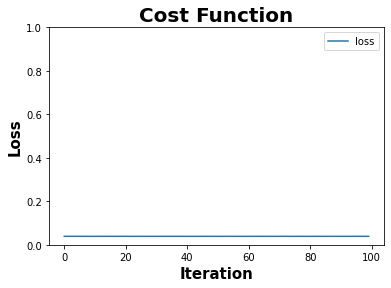

313/313 [==============================] - 0s 451us/step
TN, FP, FN, TP: 9105 45 343 507
Accuracy = 0.9612
Precesion = 0.9184782608695652
Recall = 0.5964705882352941
F1 = 0.7232524964336662
F0.5 = 0.828973185088293
F2 = 0.6414473684210525
Gmean = 0.770413607308399
Balanced Accu. = 0.7957762777242043
################################################## 9th CV ##################################################


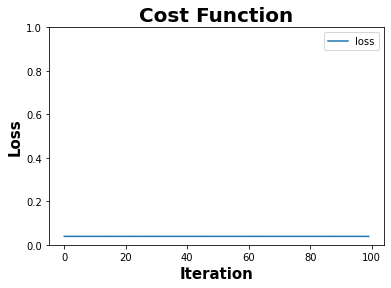

313/313 [==============================] - 0s 445us/step
TN, FP, FN, TP: 9108 42 350 500
Accuracy = 0.9608
Precesion = 0.922509225092251
Recall = 0.5882352941176471
F1 = 0.7183908045977011
F0.5 = 0.8283631544068919
F2 = 0.6341958396752917
Gmean = 0.7652027167265101
Balanced Accu. = 0.7918225650916104
################################################## 10th CV ##################################################


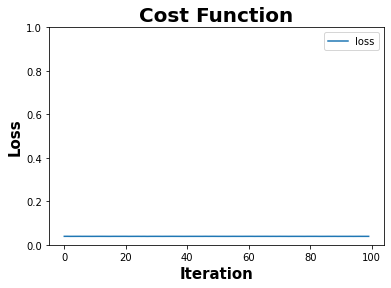

313/313 [==============================] - 0s 449us/step
TN, FP, FN, TP: 9104 46 341 509
Accuracy = 0.9613
Precesion = 0.9171171171171171
Recall = 0.5988235294117648
F1 = 0.7245551601423488
F0.5 = 0.8289902280130294
F2 = 0.6434892541087232
Gmean = 0.7718892734492999
Balanced Accu. = 0.7968981035036966


In [143]:
acc_acc = []
acc_f1 = []
acc_f5 = []
acc_f2 = []
acc_gmean = []
acc_bacc = []


n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  
print('batch_size: ', batch_size)
learning_rate=0.01

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(diab_df, diab_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'accuracy', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    acc_acc.append((TP+TN)/(TP+TN+FP+FN))
    acc_f1.append(TP / (TP + 0.5*(FP+FN)))
    acc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    acc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    acc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    acc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [144]:
res['AccAim'] = [np.mean(acc_acc), np.mean(acc_f1), np.mean(acc_f5), np.mean(acc_f2), np.mean(acc_gmean), np.mean(acc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.961200,0,0,0,0,0
F1,0,0,0.724056,0,0,0,0,0
F.5,0,0,0.827788,0,0,0,0,0
F2,0,0,0.643481,0,0,0,0,0
Gmean,0,0,0.771942,0,0,0,0,0
B_Acc,0,0,0.796950,0,0,0,0,0


batch_size:  4500
################################################## 1th CV ##################################################


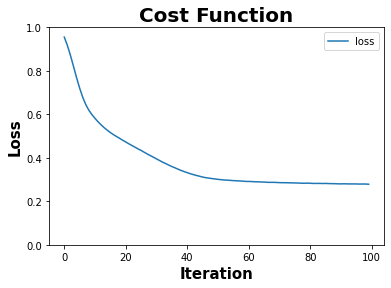

313/313 [==============================] - 0s 448us/step
TN, FP, FN, TP: 9054 96 299 551
Accuracy = 0.9605
Precesion = 0.8516228748068007
Recall = 0.648235294117647
F1 = 0.7361389445557782
F0.5 = 0.8013379872018617
F2 = 0.6807511737089201
Gmean = 0.800895834009306
Balanced Accu. = 0.8188717454194793
################################################## 2th CV ##################################################


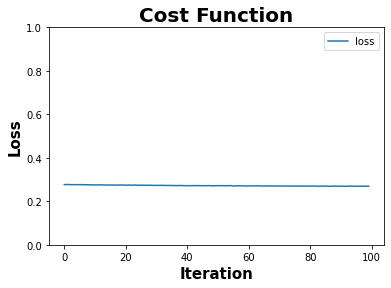

313/313 [==============================] - 0s 450us/step
TN, FP, FN, TP: 9029 121 288 562
Accuracy = 0.9591
Precesion = 0.8228404099560761
Recall = 0.6611764705882353
F1 = 0.7332028701891715
F0.5 = 0.7844779452819655
F2 = 0.6882194464854273
Gmean = 0.8077332753064511
Balanced Accu. = 0.8239762134361941
################################################## 3th CV ##################################################


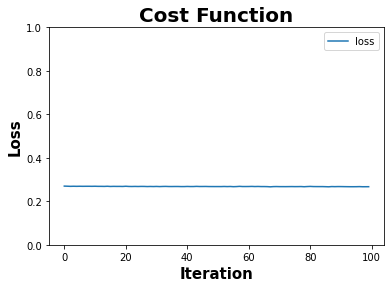

313/313 [==============================] - 0s 446us/step
TN, FP, FN, TP: 9049 101 304 546
Accuracy = 0.9595
Precesion = 0.8438948995363215
Recall = 0.6423529411764706
F1 = 0.7294589178356713
F0.5 = 0.7940663176265271
F2 = 0.6745737583395107
Gmean = 0.7970335550941365
Balanced Accu. = 0.8156573449051752
################################################## 4th CV ##################################################


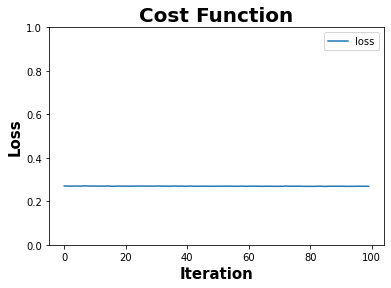

313/313 [==============================] - 0s 446us/step
TN, FP, FN, TP: 9055 95 278 572
Accuracy = 0.9627
Precesion = 0.8575712143928036
Recall = 0.6729411764705883
F1 = 0.7541199736321688
F0.5 = 0.8129619101762364
F2 = 0.7032210474551267
Gmean = 0.8160602646328866
Balanced Accu. = 0.8312793314046931
################################################## 5th CV ##################################################


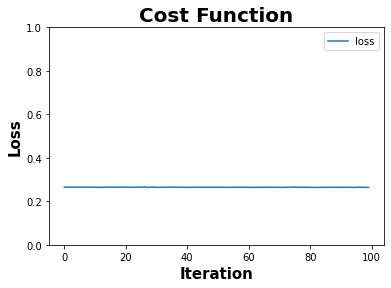

313/313 [==============================] - 0s 444us/step
TN, FP, FN, TP: 9037 113 309 541
Accuracy = 0.9578
Precesion = 0.827217125382263
Recall = 0.6364705882352941
F1 = 0.7194148936170213
F0.5 = 0.7804385458742067
F2 = 0.6672422298963986
Gmean = 0.7928495130664179
Balanced Accu. = 0.8120604307296689
################################################## 6th CV ##################################################


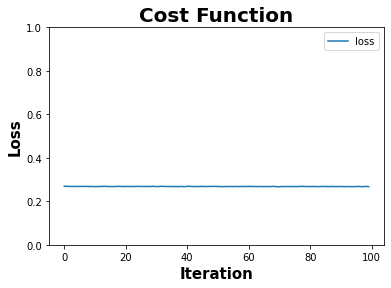

313/313 [==============================] - 0s 448us/step
TN, FP, FN, TP: 9044 106 278 572
Accuracy = 0.9616
Precesion = 0.8436578171091446
Recall = 0.6729411764705883
F1 = 0.7486910994764397
F0.5 = 0.8029197080291971
F2 = 0.7013241785188817
Gmean = 0.8155644396313861
Balanced Accu. = 0.8306782385085182
################################################## 7th CV ##################################################


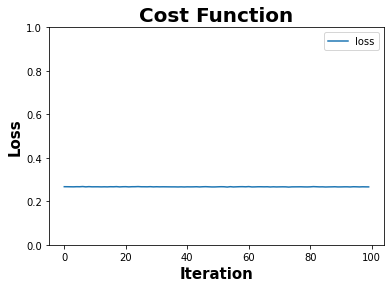

313/313 [==============================] - 0s 449us/step
TN, FP, FN, TP: 9050 100 287 563
Accuracy = 0.9613
Precesion = 0.8491704374057315
Recall = 0.6623529411764706
F1 = 0.744216787838731
F0.5 = 0.8038263849229013
F2 = 0.6928378045778981
Gmean = 0.8093911978878061
Balanced Accu. = 0.8257119897139183
################################################## 8th CV ##################################################


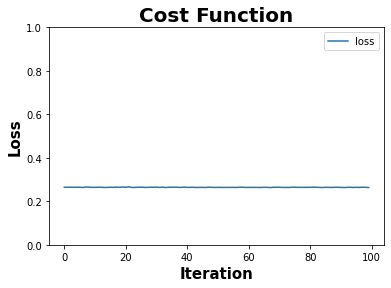

313/313 [==============================] - 0s 442us/step
TN, FP, FN, TP: 9049 101 306 544
Accuracy = 0.9593
Precesion = 0.8434108527131783
Recall = 0.64
F1 = 0.7277591973244147
F0.5 = 0.793002915451895
F2 = 0.6724351050679852
Gmean = 0.7955724474400072
Balanced Accu. = 0.8144808743169398
################################################## 9th CV ##################################################


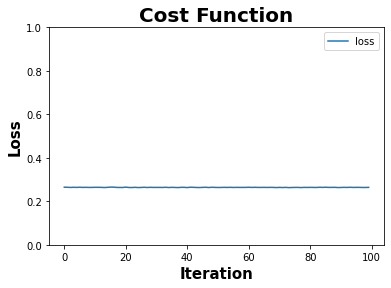

313/313 [==============================] - 0s 468us/step
TN, FP, FN, TP: 9047 103 306 544
Accuracy = 0.9591
Precesion = 0.8408037094281299
Recall = 0.64
F1 = 0.7267869071476286
F0.5 = 0.7911576497963932
F2 = 0.6721027921917468
Gmean = 0.795484524309116
Balanced Accu. = 0.8143715846994535
################################################## 10th CV ##################################################


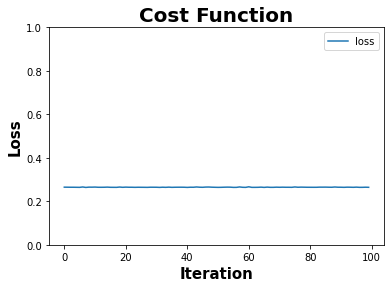

313/313 [==============================] - 0s 457us/step
TN, FP, FN, TP: 9050 100 296 554
Accuracy = 0.9604
Precesion = 0.8470948012232415
Recall = 0.6517647058823529
F1 = 0.7367021276595744
F0.5 = 0.7991921523369878
F2 = 0.6832757770103601
Gmean = 0.8028957555888904
Balanced Accu. = 0.8204178720668596


In [146]:
f1_acc = []
f1_f1 = []
f1_f5 = []
f1_f2 = []
f1_gmean = []
f1_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  
print('batch_size: ', batch_size)
learning_rate=0.02

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(diab_df, diab_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'f1_score', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    f1_acc.append((TP+TN)/(TP+TN+FP+FN))
    f1_f1.append(TP / (TP + 0.5*(FP+FN)))
    f1_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    f1_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    f1_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    f1_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [147]:
res['F1Aim'] = [np.mean(f1_acc), np.mean(f1_f1), np.mean(f1_f5), np.mean(f1_f2), np.mean(f1_gmean), np.mean(f1_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.961200,0.960130,0,0,0,0
F1,0,0,0.724056,0.735649,0,0,0,0
F.5,0,0,0.827788,0.796338,0,0,0,0
F2,0,0,0.643481,0.683598,0,0,0,0
Gmean,0,0,0.771942,0.803348,0,0,0,0
B_Acc,0,0,0.796950,0.820751,0,0,0,0


batch_size:  45000
################################################## 1th CV ##################################################


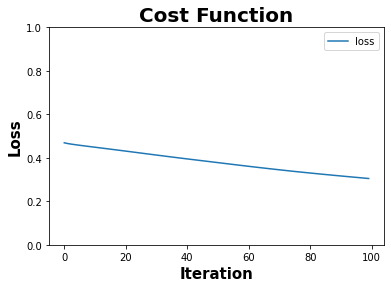

313/313 [==============================] - 0s 453us/step
TN, FP, FN, TP: 7891 1259 276 574
Accuracy = 0.8465
Precesion = 0.3131478450627387
Recall = 0.6752941176470588
F1 = 0.4278792396571003
F0.5 = 0.3507699828892691
F2 = 0.5484425759602523
Gmean = 0.7631360292662481
Balanced Accu. = 0.7688492446158791
################################################## 2th CV ##################################################


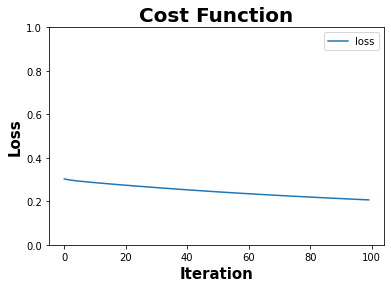

313/313 [==============================] - 0s 459us/step
TN, FP, FN, TP: 7381 1769 135 715
Accuracy = 0.8096
Precesion = 0.28784219001610306
Recall = 0.8411764705882353
F1 = 0.4289142171565687
F0.5 = 0.33144817355831635
F2 = 0.6075798776342625
Gmean = 0.823740869210605
Balanced Accu. = 0.823921568627451
################################################## 3th CV ##################################################


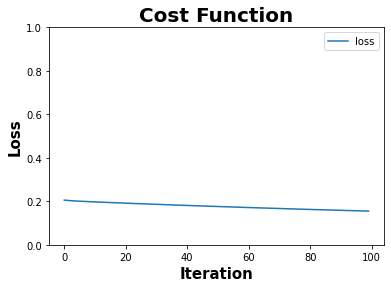

313/313 [==============================] - 0s 477us/step
TN, FP, FN, TP: 7777 1373 100 750
Accuracy = 0.8527
Precesion = 0.3532736693358455
Recall = 0.8823529411764706
F1 = 0.5045408678102926
F0.5 = 0.4014129736673089
F2 = 0.6789788158609452
Gmean = 0.8659975658119862
Balanced Accu. = 0.8661491481838637
################################################## 4th CV ##################################################


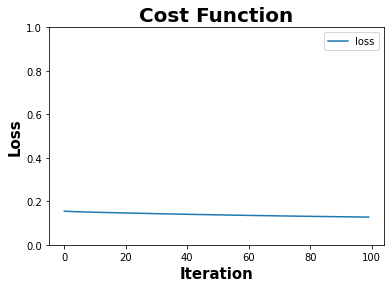

313/313 [==============================] - 0s 480us/step
TN, FP, FN, TP: 8025 1125 100 750
Accuracy = 0.8775
Precesion = 0.4
Recall = 0.8823529411764706
F1 = 0.5504587155963303
F0.5 = 0.4491017964071856
F2 = 0.7109004739336493
Gmean = 0.8796970636637977
Balanced Accu. = 0.8797010607521697
################################################## 5th CV ##################################################


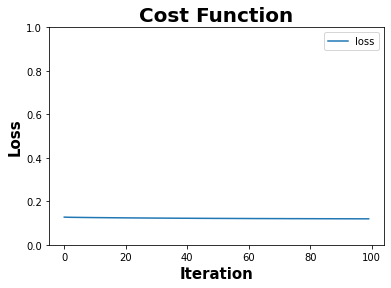

313/313 [==============================] - 0s 492us/step
TN, FP, FN, TP: 8014 1136 86 764
Accuracy = 0.8778
Precesion = 0.40210526315789474
Recall = 0.8988235294117647
F1 = 0.5556363636363636
F0.5 = 0.4520710059171597
F2 = 0.720754716981132
Gmean = 0.8872608899602765
Balanced Accu. = 0.8873352619736419
################################################## 6th CV ##################################################


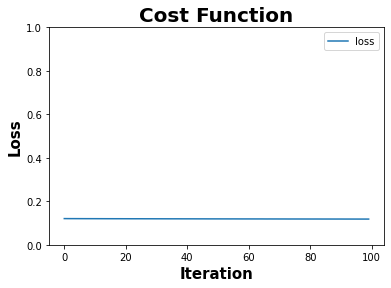

313/313 [==============================] - 0s 478us/step
TN, FP, FN, TP: 8007 1143 74 776
Accuracy = 0.8783
Precesion = 0.4043772798332465
Recall = 0.9129411764705883
F1 = 0.5604911520404479
F0.5 = 0.4550785831574009
F2 = 0.729460424891897
Gmean = 0.893811143729892
Balanced Accu. = 0.8940115718418515
################################################## 7th CV ##################################################


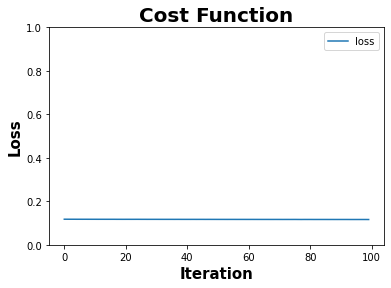

313/313 [==============================] - 0s 464us/step
TN, FP, FN, TP: 7919 1231 77 773
Accuracy = 0.8692
Precesion = 0.38572854291417163
Recall = 0.9094117647058824
F1 = 0.5416958654519972
F0.5 = 0.4359350327092262
F2 = 0.7152109548482606
Gmean = 0.8871660390491585
Balanced Accu. = 0.8874381227900996
################################################## 8th CV ##################################################


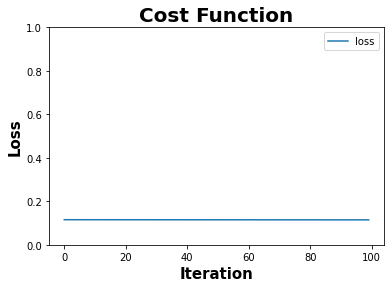

313/313 [==============================] - 0s 470us/step
TN, FP, FN, TP: 7961 1189 92 758
Accuracy = 0.8719
Precesion = 0.38931689779147405
Recall = 0.8917647058823529
F1 = 0.5420092956739364
F0.5 = 0.43875897198425556
F2 = 0.7088086777632318
Gmean = 0.880842792119822
Balanced Accu. = 0.8809096753455481
################################################## 9th CV ##################################################


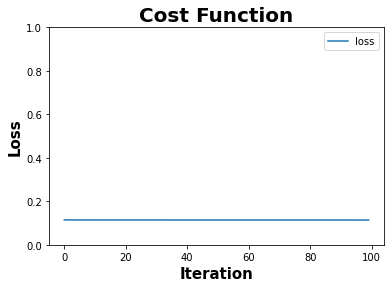

313/313 [==============================] - 0s 482us/step
TN, FP, FN, TP: 7959 1191 98 752
Accuracy = 0.8711
Precesion = 0.3870303654143078
Recall = 0.8847058823529412
F1 = 0.5384890798424633
F0.5 = 0.43609371375550915
F2 = 0.7037244993449372
Gmean = 0.877239467817
Balanced Accu. = 0.8772709739633558
################################################## 10th CV ##################################################


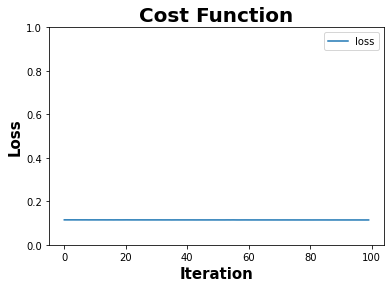

313/313 [==============================] - 0s 469us/step
TN, FP, FN, TP: 7927 1223 80 770
Accuracy = 0.8697
Precesion = 0.386352232814852
Recall = 0.9058823529411765
F1 = 0.5416813225466057
F0.5 = 0.4364089775561097
F2 = 0.7138883738179121
Gmean = 0.8858899641649434
Balanced Accu. = 0.8861105753776921


In [152]:
bacc_acc = []
bacc_f1 = []
bacc_f5 = []
bacc_f2 = []
bacc_gmean = []
bacc_bacc = []


n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.5)  
print('batch_size: ', batch_size)
learning_rate=0.03

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(diab_df, diab_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'bacc', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    bacc_acc.append((TP+TN)/(TP+TN+FP+FN))
    bacc_f1.append(TP / (TP + 0.5*(FP+FN)))
    bacc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    bacc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    bacc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    bacc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [153]:
res['BAim'] = [np.mean(bacc_acc), np.mean(bacc_f1), np.mean(bacc_f5), np.mean(bacc_f2), np.mean(bacc_gmean), np.mean(bacc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.961200,0.960130,0,0,0,0.862430
F1,0,0,0.724056,0.735649,0,0,0,0.519180
F.5,0,0,0.827788,0.796338,0,0,0,0.418708
F2,0,0,0.643481,0.683598,0,0,0,0.683775
Gmean,0,0,0.771942,0.803348,0,0,0,0.864478
B_Acc,0,0,0.796950,0.820751,0,0,0,0.865170
